# Neogen Pesticide Analysis
- **Team Members:** Uta Nishii, Xian Sun, Jackson Peacock, Tabitha Weinbrenner


# Background and Motivation:
To determine what foods contain pesticide residues or combinations of 
pesticide residues that exceed maximum residue limits, or may pose a concern for human and animal 
health.

# Goals:
- Identify the pesticides that impact the environment the most.
- Identify the pesticides most harmful to human and animal health.
- Identify the food products and pesticides with concentrations exceeding EPA thresholds​
- Identify the food products containing multiple pesticides.
- Identify trends in pesticides over time.

##  This reports intended purpose is to answer our individual questions, and present the results we have found in a single notebook. 

### The questions are as follows:
- 1. Pesticides with the biggest impact on the environment in the next 3-5 years? 
- 2. What pesticides will have the biggest impact on human and animal health in the next 3-5 years? 
- 3. Which food products have pesticide residue levels that exceed FDA and EPA thresholds? Related information about top 12 commodities, "The Dirty Dozen."  
- 4. Are there trends in pesticide residue levels on foods over time, by food product, by location, by quantity (tonnage) of pesticides manufactured, by pesticide toxicity or environmental impact, by pesticide class that could be used to predict issues with certain foods? 

## How the data was retrieved:

**The data for this project was gathered from the PDP Database, which is a national pesticide residue monitoring program and produces the most comprehensive pesticide residue database in the U.S.**
- The website https://www.ams.usda.gov/datasets/pdp has the database.

There is a link to the PDP Database Search where the data can be filtered for specific commodities, pesticides or years. For the purposes of this project, commodities and pesticides were gathered for all years. By checking the box for all commodities, all pesticides and all years, as well as setting the output preference to Analytical Results and the results preference to Positive Detects Only, the dataset can be downloaded. This gives the analytical results for only cases where there was a positive detect of pesticides. The analytical results output allows for analysis on the most relevant columns. From this point, once the data loads there is a button to Export to Excel. This will download the selected data as a csv file which can then be loaded into Python using the packages below.

# Below this cell, we include the individual question methods and their results explained through markdown cells and code.
- Any additional information regarding research and pesticides outside of the PDP database will be included at the end of the document.

### Importing packages and data:

In [1]:
import pandas as pd
import numpy as np
import csv
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import csv
import re
from pmdarima.arima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [5]:
# Read in PDP data
df = pd.read_csv('PDP_Positive_Detects_1994-2021.csv',low_memory = False)

# Includes Data outside PDP Database:
PDP_Data = pd.read_csv('PDP_Positive_Detects_1994-2021.csv',low_memory = False)
FDA_2020 = pd.read_csv("CountryProductResidue2020.txt",delim_whitespace=True)
FAOPest_Amount = pd.read_csv('FAOSTAT_PestDataUS.csv')
FAOPest_Area = pd.read_csv('FAOSTAT_PestPerArea.csv')


# 1. Pesticides with the biggest impact on the environment in the next 3-5 years?


In [16]:
dates = []      #extract the dates from Sample ID
for i in range(len(df)):
    sample_id = df["Sample ID"][i]
    year = sample_id[2:4]
    if (int(year) < 90):
        year = '20'+ year
    else:
        year = '19' + year
    month = sample_id[4:6]
    day = sample_id[6:8]
    d = year + '-' + month + '-' + day
    date = pd.to_datetime(d)
    dates.append(date)
df["Date"] = dates
# Convert parts per trillion to parts per million where pp_ is 'T'
df.loc[df['pp_'] == 'T', 'Concentration'] = df['Concentration'] / 1000000
df.loc[df['pp_'] == 'T', 'LOD'] = df['LOD'] / 1000000
df.loc[df['pp_'] == 'T', 'pp_'] = 'M'
df = df.drop('Sample ID', axis=1)  #drop sample id
df.sort_values(by="Date", inplace=True)
df.head()

Commod Pesticide Code     Pesticide Name Test Class  Concentration  \
124746     CR            300                DDE          A          0.011   
169796     GB            164     Chlorothalonil          A          0.033   
169797     GB            115  Endosulfans Total          A          0.167   
169798     GB            115  Endosulfans Total          A          0.009   
169799     GB            164     Chlorothalonil          A          0.260   

          LOD pp_ Confirm 1 Confirm 2 Annotate Quantitate Mean Extract  \
124746  0.006   M         M       NaN        Q          M    O     NaN   
169796  0.008   M         D       NaN      NaN          M    O     NaN   
169797  0.005   M         D         M      NaN          M    O     NaN   
169798  0.005   M         D       NaN        Q          M    O     NaN   
169799  0.008   M         D         M      NaN          M    O     NaN   

        Determ EPA Tolerance (ppm)       Date  
124746     NaN                3 AL 1994-01-03  
169796     NaN                   5 1994-01-03  
169797     NaN                   2 1994-01-03  
169798     NaN                   2 1994-01-03  
169799     NaN                   5 1994-01-03

In [17]:
EPA = list(df["EPA Tolerance (ppm)"])
numbers = []
for i in EPA:
    if isinstance(i,str):
        # Find number or decimal in the column, exlude nan or otherwise:
        match = re.findall(r'\d+(?:\.\d+)?', i)
        if len(match) == 1:
            numbers.append(float(match[0]))
        elif len(match) == 2:
            numbers.append(float(match[0])/float(match[1]))
        else:
            numbers.append(np.nan)
    else:
        numbers.append(np.nan)
df["New EPA"] = numbers
df = df.dropna(subset=['New EPA'])
exceed = df[df.Concentration.gt(df["New EPA"])]
exceed.head()

Commod Pesticide Code       Pesticide Name Test Class  Concentration  \
218717     GR            512  3-Hydroxycarbofuran          E           0.34   
53195      BN            604             Imazalil          N           0.36   
169382     GB            204             Acephate          C           3.30   
216358     GR            512  3-Hydroxycarbofuran          E           0.32   
411278     SP            171           Dimethoate          C          11.00   

          LOD pp_ Confirm 1 Confirm 2 Annotate Quantitate Mean Extract  \
218717  0.023   M         I       NaN        X          H    A     NaN   
53195   0.030   M         M       NaN        X          H    A     NaN   
169382  0.005   M         M       NaN        X          M    A     NaN   
216358  0.021   M         I       NaN        X          H    A     NaN   
411278  0.032   M         M       NaN        X          H    A      15   

        Determ EPA Tolerance (ppm)       Date  New EPA  
218717     NaN                 0.2 1994-01-11      0.2  
53195      NaN                 0.2 1994-03-23      0.2  
169382     NaN                   3 1994-10-24      3.0  
216358     NaN                 0.2 1995-01-03      0.2  
411278    16.0                   2 1995-04-11      2.0

Create a new dataset only containing the variables we need.

In [18]:
data = df[['Date','Pesticide Name', 'Concentration','New EPA']]
data = data.dropna(subset=['New EPA'])
data['Percent of Threshold'] = (data['Concentration'] / data['New EPA']) * 100
data.head()

Date     Pesticide Name  Concentration  New EPA  \
124746 1994-01-03                DDE          0.011      3.0   
169796 1994-01-03     Chlorothalonil          0.033      5.0   
169797 1994-01-03  Endosulfans Total          0.167      2.0   
169798 1994-01-03  Endosulfans Total          0.009      2.0   
169799 1994-01-03     Chlorothalonil          0.260      5.0   

        Percent of Threshold  
124746              0.366667  
169796              0.660000  
169797              8.350000  
169798              0.450000  
169799              5.200000

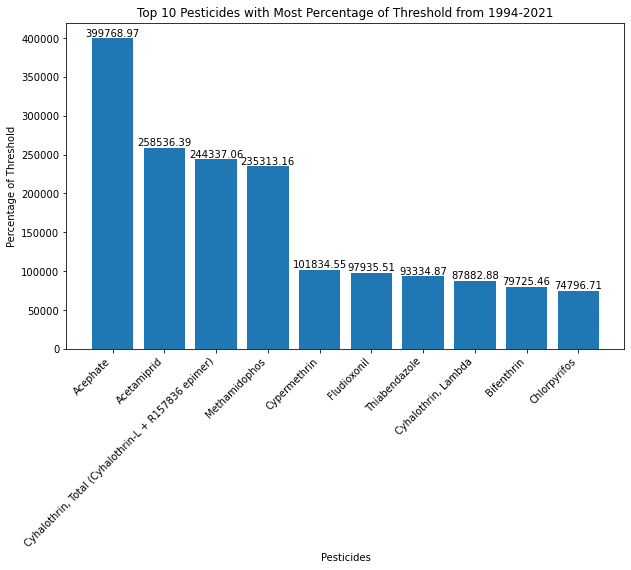

In [19]:
pest_sort = data.groupby('Pesticide Name')['Percent of Threshold'].sum()
pest_sort.sort_values(inplace=True,ascending=False)
top_pest = pest_sort.index[:10].values
plt.figure(figsize=(10,6))
plt.bar(top_pest, pest_sort.values[:10])
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Pesticides with Most Percentage of Threshold from 1994-2021")
plt.xlabel("Pesticides")
plt.ylabel("Percentage of Threshold")
for i, v in enumerate(pest_sort.values[:10]):
        plt.annotate("{:.2f}".format(v), xy=(i, v), xytext=(i, v+0.5),
                 ha='center', va='bottom')
plt.show()

In [20]:
df[df['Pesticide Name'] == 'Cyhalothrin, Lambda'].tail()

Commod Pesticide Code       Pesticide Name Test Class  Concentration  \
398340     SN            AEM  Cyhalothrin, Lambda          O         0.0033   
398350     SN            AEM  Cyhalothrin, Lambda          O         0.0075   
395442     SN            AEM  Cyhalothrin, Lambda          O         0.0142   
395454     SN            AEM  Cyhalothrin, Lambda          O         0.0033   
395448     SN            AEM  Cyhalothrin, Lambda          O         0.0336   

          LOD pp_ Confirm 1 Confirm 2 Annotate Quantitate Mean Extract  \
398340  0.002   M        GT       NaN        Q        NaN    O     805   
398350  0.002   M        GT       NaN      NaN        NaN    O     805   
395442  0.002   M        GT       NaN      NaN        NaN    O     805   
395454  0.002   M        GT       NaN        Q        NaN    O     805   
395448  0.002   M        GT       NaN      NaN        NaN    O     805   

        Determ EPA Tolerance (ppm)       Date  New EPA  
398340    35.0                 0.2 2018-12-18      0.2  
398350    35.0                 0.2 2018-12-18      0.2  
395442    35.0                 0.2 2018-12-19      0.2  
395454    35.0                 0.2 2018-12-19      0.2  
395448    35.0                 0.2 2018-12-19      0.2

**'Cyhalothrin, Lambda' do not have data after 2018 so we dropped those pesticides.**

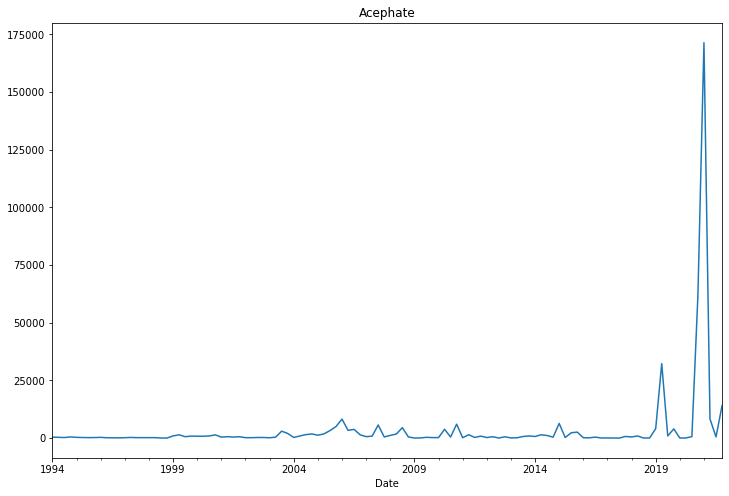

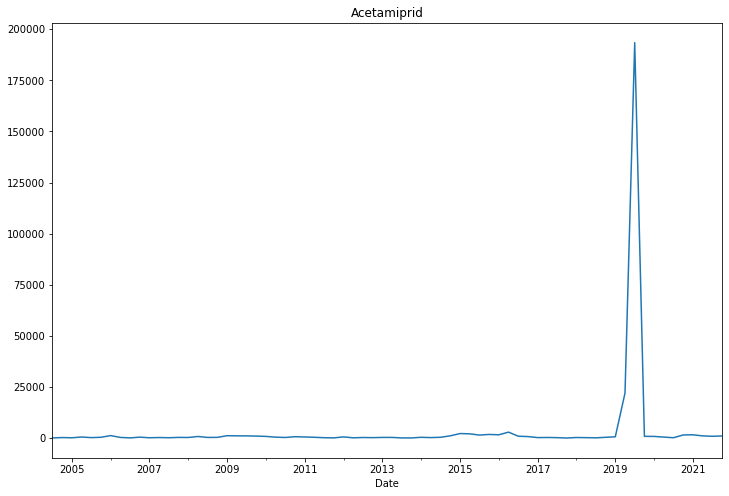

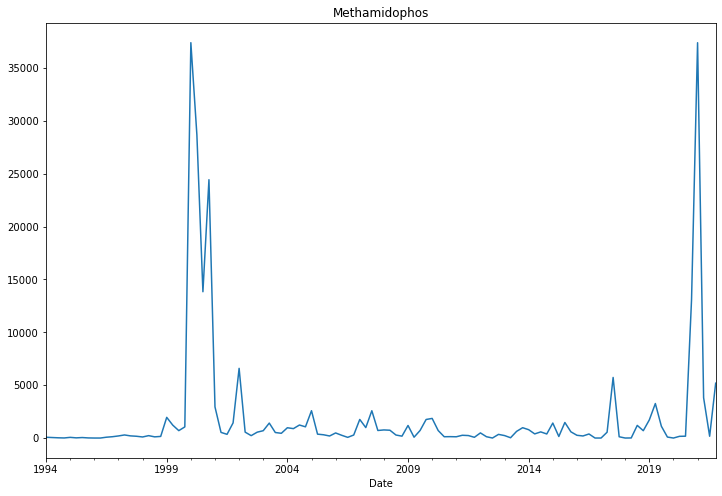

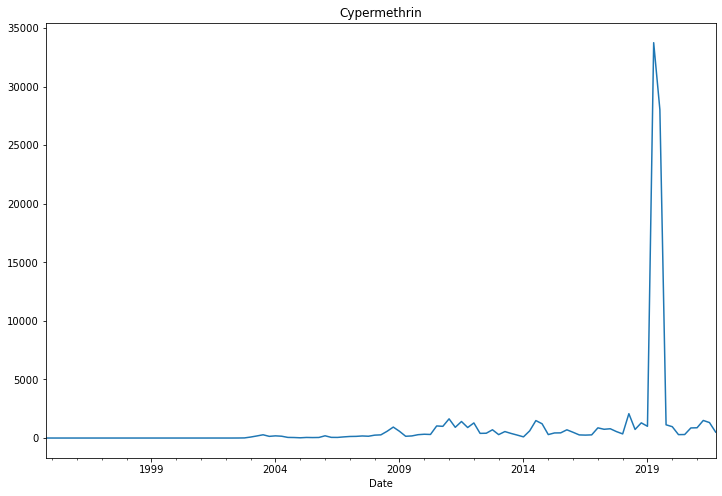

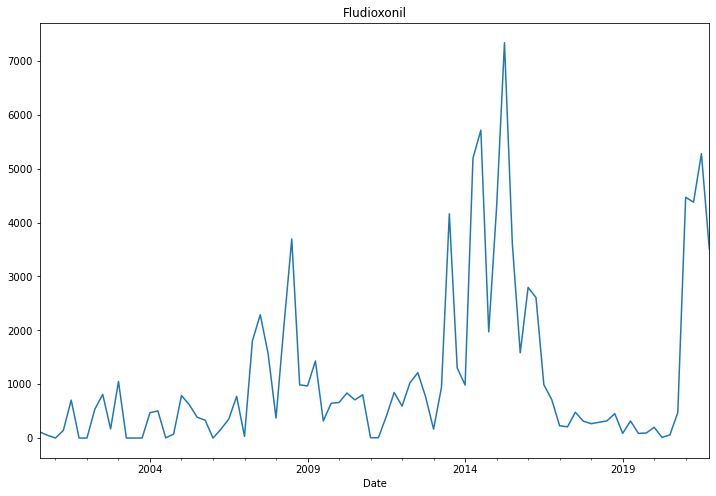

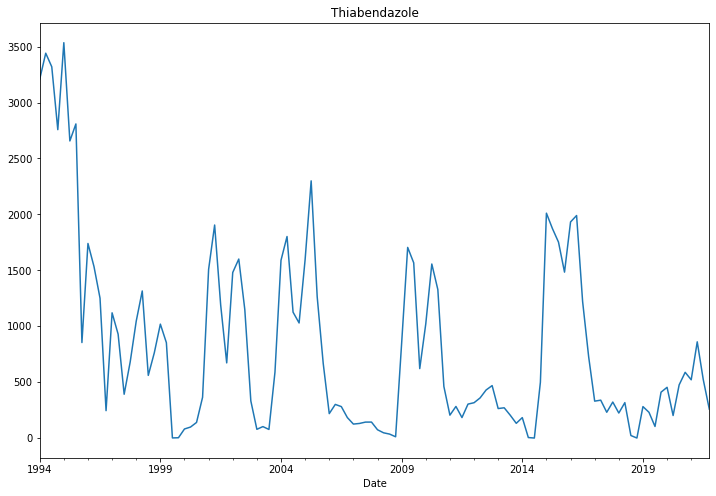

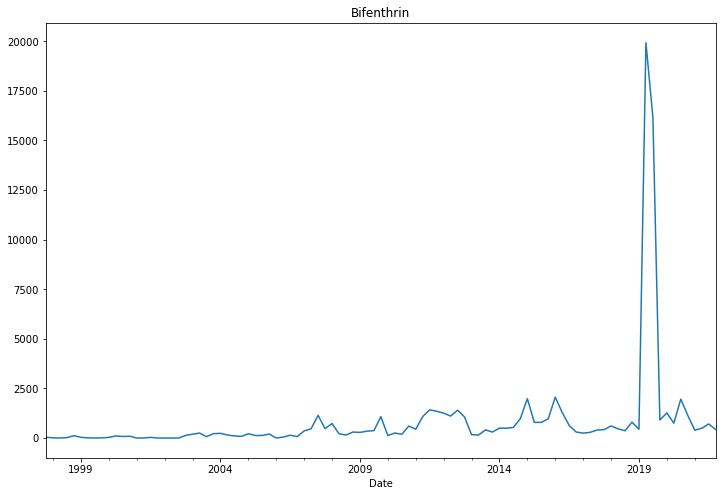

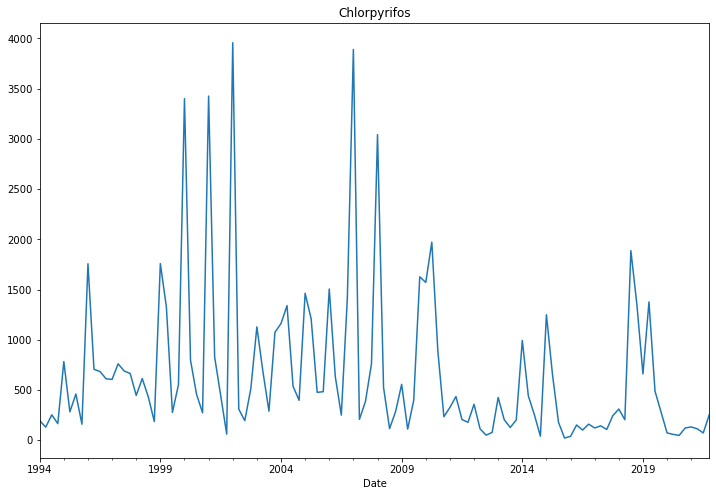

In [21]:
index = np.where(top_pest == 'Cyhalothrin, Lambda')[0]
top_pest = np.delete(top_pest, index)
for p in top_pest:
    top = data[data['Pesticide Name'] == p]
    top = top.set_index('Date')
    top = top.dropna()
    # create a time series with sesonal frequency
    ts = top['Percent of Threshold'].resample('Q').sum()
    ts.fillna(0, inplace=True)
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)
    ts.plot()
    plt.title(p)

Based on the trends of percentage of threshold, I'm going to remove some outliers from several pesticides before building the model

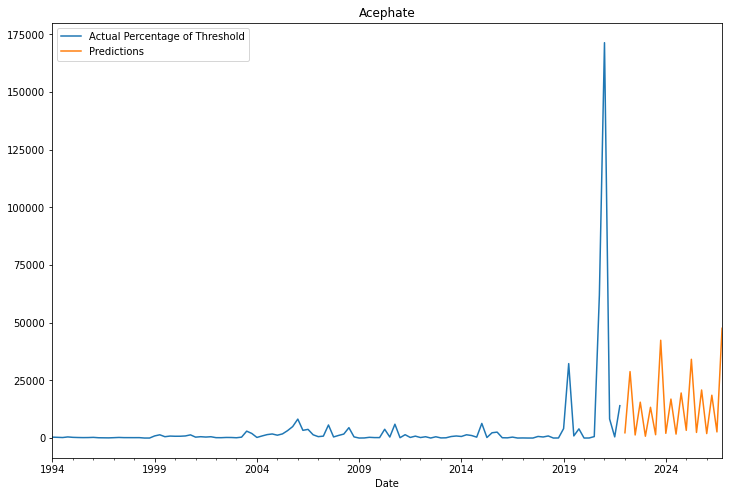

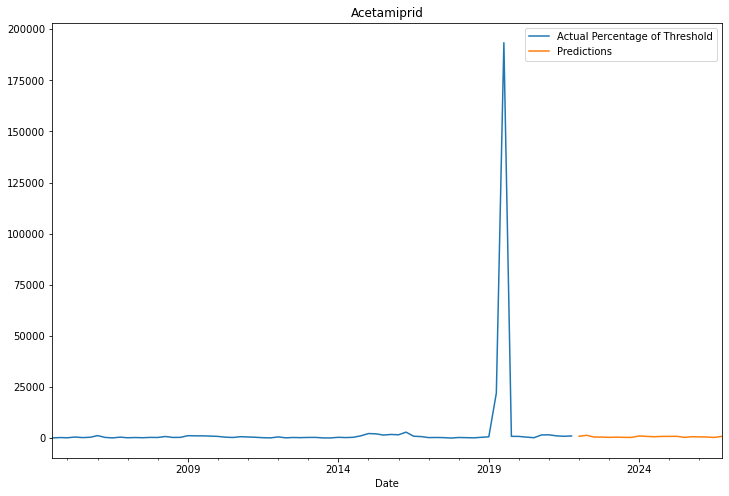

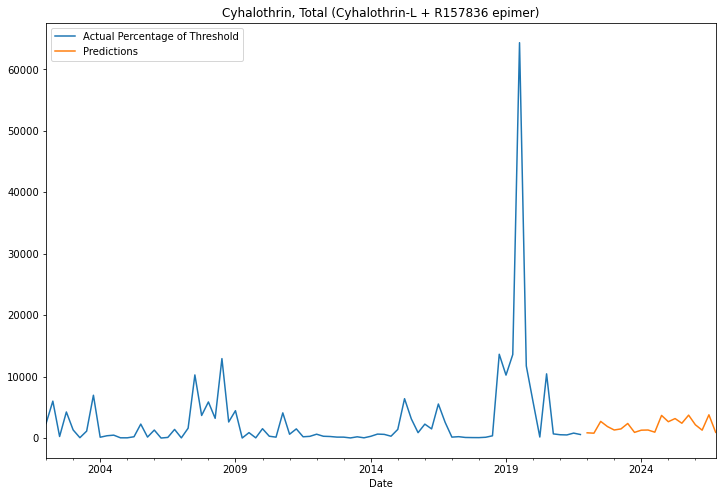

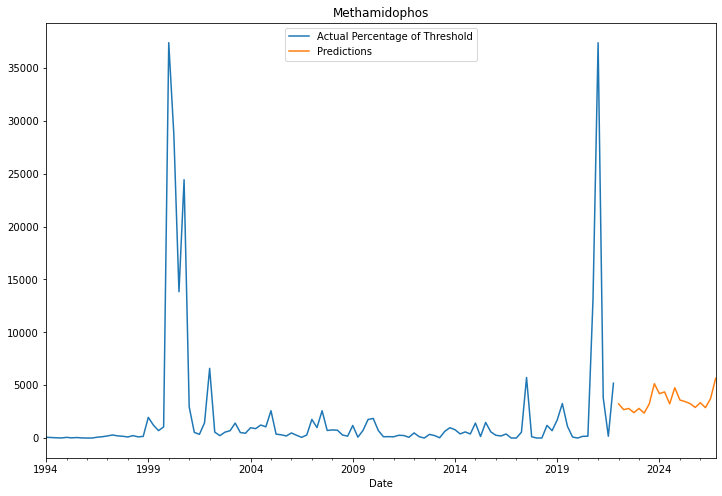

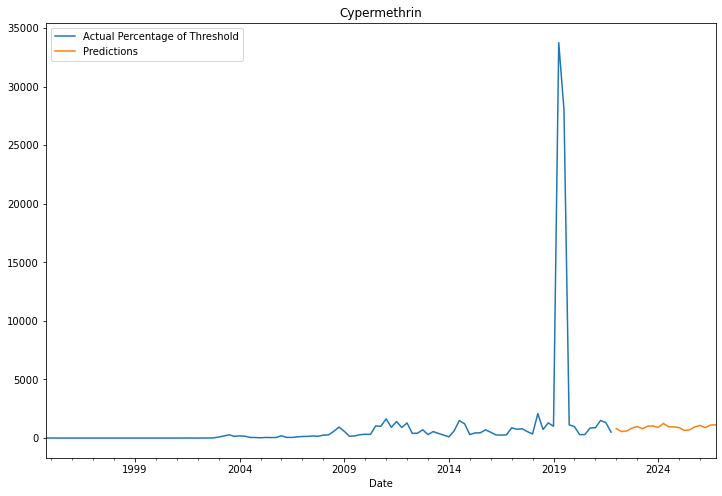

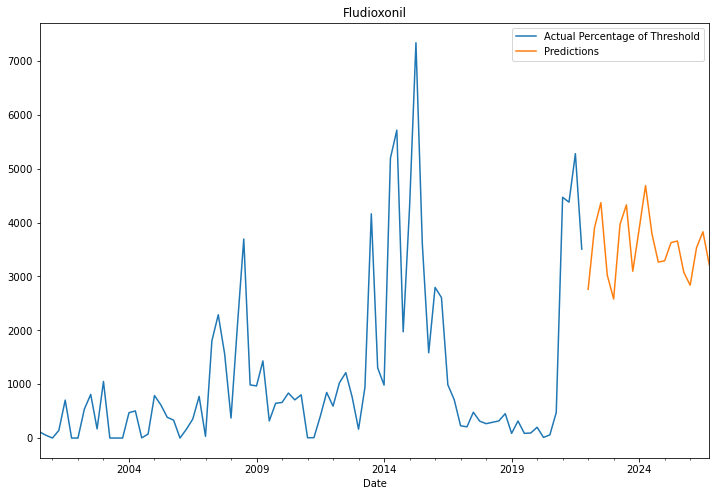

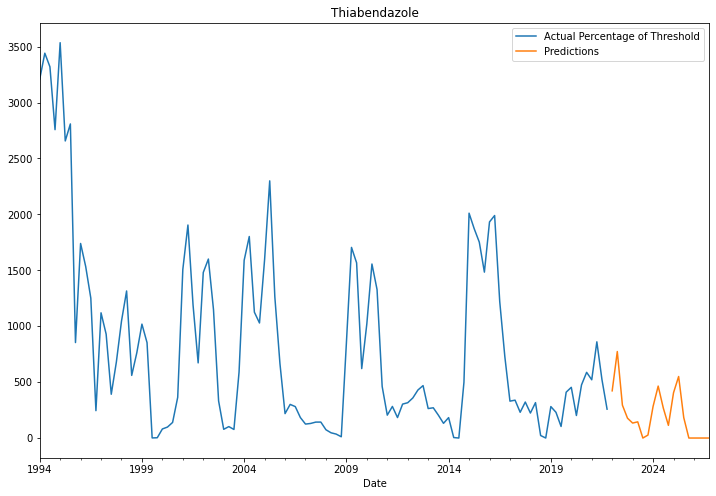

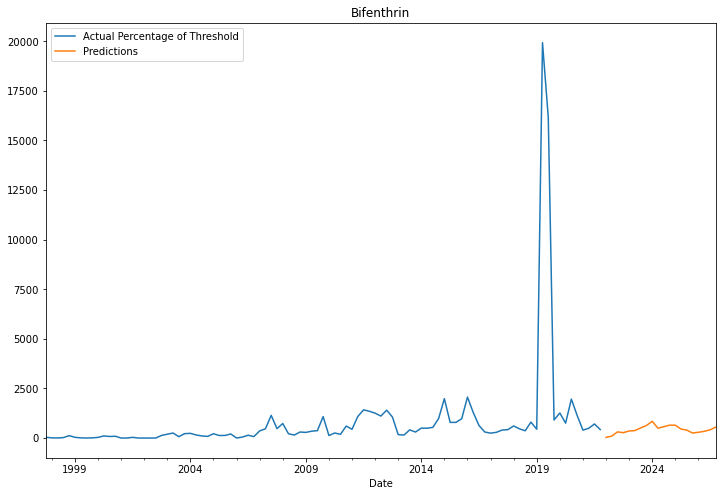

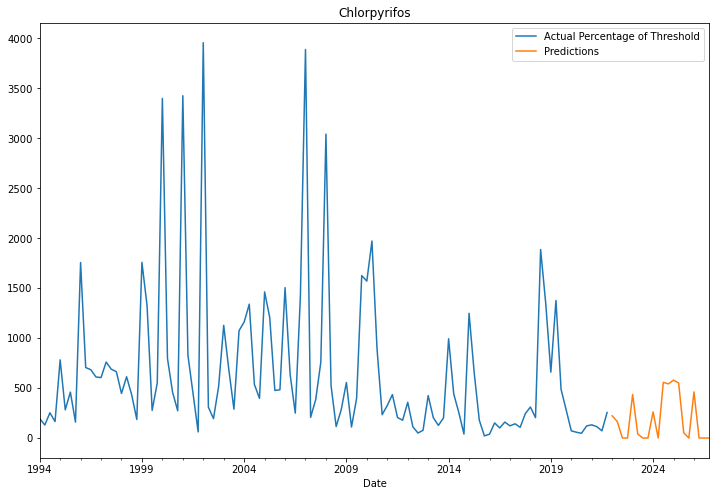

In [24]:
predictions = {}
for p in top_pest:
    top = data[data['Pesticide Name'] == p]
    top = top.set_index('Date')
    top = top.dropna()
    # create a time series with sesonal frequency
    ts = top['Percent of Threshold'].resample('Q').sum()
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)
    ts.plot(label='Actual Percentage of Threshold')
    # get rid of outliers manually
    if p == 'Cypermethrin':
        ts['2019-06-30'] = 0
        ts['2019-09-30'] = 0
    if p == 'Acephate':
        ts['2021-03-31'] = 0
    if p == 'Acetamiprid':
        ts['2019-09-30'] = 0
        ts['2019-06-30'] = 0
    if p == 'Bifenthrin':
        ts['2019-09-30'] = 0
        ts['2019-06-30'] = 0
    if p == 'Methamidophos':
        ts['2021-03-31']=  0
    if p == 'Cyhalothrin, Total (Cyhalothrin-L + R157836 epimer)':
        ts['2019-09-30'] = 0
    ts.fillna(0, inplace=True) # replace the NaN values with 0
    model = auto_arima(ts,start_p=1, start_q=1,
                   max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1,error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
    model.fit(ts)
    preds = model.predict(n_periods=20)  #set the period to 5 years
    preds = preds.apply(lambda x: 0 if x < 0 else x)
    predictions[p] = preds
    preds.plot(label='Predictions')
    plt.legend()
    plt.title(p)
means = []
for p in predictions.values():
    m = p.mean()
    means.append(m)
results = pd.DataFrame(list(zip(top_pest, means)), columns=['Pesticide', 'Mean Percent of Threshold'])
results.sort_values(by='Mean Percent of Threshold',inplace=True,ascending=False)
results.reset_index(inplace=True)

In [25]:
results

index                                          Pesticide  \
0      0                                           Acephate   
1      5                                        Fludioxonil   
2      3                                      Methamidophos   
3      2  Cyhalothrin, Total (Cyhalothrin-L + R157836 ep...   
4      4                                       Cypermethrin   
5      1                                        Acetamiprid   
6      7                                         Bifenthrin   
7      6                                      Thiabendazole   
8      8                                       Chlorpyrifos   

   Mean Percent of Threshold  
0               13871.168350  
1                3536.198095  
2                3498.949531  
3                1980.019995  
4                 903.970653  
5                 657.235281  
6                 423.500281  
7                 211.929920  
8                 193.426987

### What products are these pesticides found in the most?

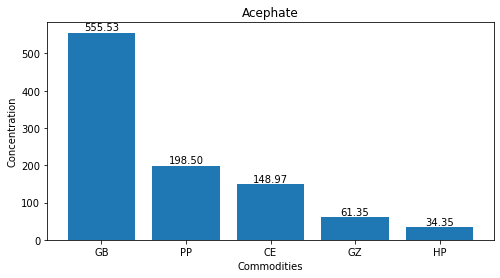

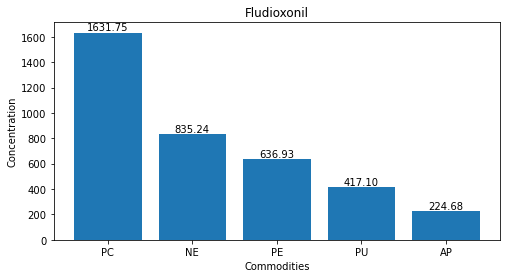

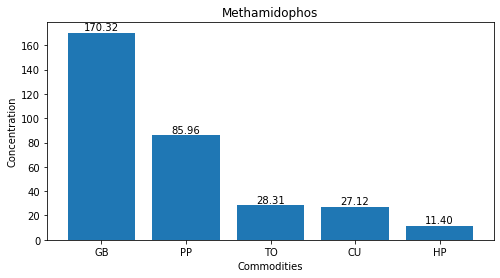

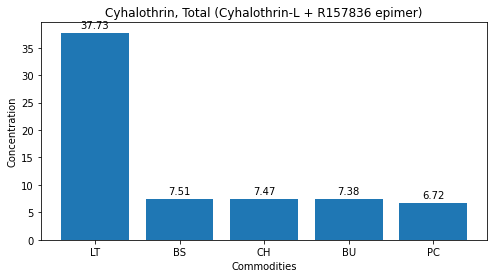

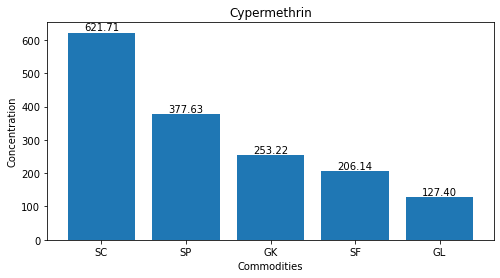

In [26]:
harmful = results['Pesticide'][:5].values
for i in harmful:
    pest = df[df['Pesticide Name'] == i]
    pest = pest.groupby('Commod')['Concentration'].sum()
    pest = pest.sort_values(ascending=False)
    pest = pest[:5]
    fig, axs = plt.subplots(1, 1, figsize=(8, 4))
    plt.bar(pest.index.values, pest.values)
    plt.title(i)
    plt.xlabel("Commodities")
    plt.ylabel("Concentration")
    for i, v in enumerate(pest.values):
        plt.annotate("{:.2f}".format(v), xy=(i, v), xytext=(i, v+0.5),
                 ha='center', va='bottom')

# 2. What pesticides will have the biggest impact on human and animal health in the next 3-5 years?


To answer the research question, data from the Pesticide Data Program (PDP) was analyzed. The data includes information on pesticide concentrations in various commodities collected between 1994 and 2021. (https://apps.ams.usda.gov/pdp)

## Import Packages

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

## Read Data

In [8]:
# read the data into a pandas dataframe
df = pd.read_csv('PDP_Positive_Detects_1994-2021.csv', low_memory=False)
df.head()

Sample ID Commod Pesticide Code  Pesticide Name Test Class  \
0  CA0307280363AACA1      AA            160    Chlorpyrifos          C   
1  CA0310280484AACA1      AA             83  O-Phenylphenol          I   
2  CA0311250391AACA1      AA             83  O-Phenylphenol          I   
3  FL0308220056AAFL1      AA            160    Chlorpyrifos          C   
4  MI0307280000AAFL1P     AA            160    Chlorpyrifos          C   

   Concentration     LOD pp_ Confirm 1 Confirm 2 Annotate Quantitate Mean  \
0         0.0250  0.0040   M         C         M      NaN          M    O   
1         0.0170  0.0100   M        MO       NaN       QV          H    O   
2         0.0170  0.0100   M        MO       NaN       QV          H    O   
3         0.0063  0.0038   M       NaN       NaN       Q           M    O   
4         0.0170  0.0038   M         D       NaN      NaN          M    O   

  Extract  Determ EPA Tolerance (ppm)  
0     552     2.0                   5  
1     550     7.0                  NT  
2     550     7.0                  NT  
3     802    60.0                   5  
4     551    60.0                   5

## Cleaning Data

We added a "Month" and "Year" column to the dataset using the data extracted from "sample ID" column which contains a unique sample identifer (combination of 2-letter Collection State code), 2-digit Year, 2-digit Month, 2-digit Day, 4-digit Collection Site code, 2-letter Commodity code, 3-character Analyzing Lab code, and optional 1-letter Source ID code.

In [9]:
# Create an empty list to store the extracted dates
dates = []
months = []

# Iterate through each row in the dataframe and extract the date from the "PDP Sample ID" column
for i in range(len(df)):
    sample_id = df.loc[i, "Sample ID"]
    year = sample_id[2:4]
    month = sample_id[4:6]
    day = sample_id[6:8]
    date = f"{year}-{month}-{day}"  # Assumes year is in the 21st century
    dates.append(date)
    months.append(int(month))

# Add the list of dates as a new column "Date" to the dataframe
df["Date"] = dates
df["Month"] = months

In [10]:
# Define a function to extract the year value from a date string and add the century prefix
def get_century_year(date_str):
    year = int(date_str[:2])
    if year > 90:
        century_prefix = "19"
    else:
        century_prefix = "20"
    return int(century_prefix + date_str[:2])

# Apply the get_century_year function to the date column to create the new "Year" column
df["Year"] = df["Date"].apply(get_century_year)

We then converted the "Concentration" column so all the units are in 'ppm' (parts per million) so it would be accurate when compared to the EPA Tolerance column which are all in ppm

In [11]:
# Convert parts per trillion to parts per million where pp_ is 'T'
df.loc[df['pp_'] == 'T', 'Concentration'] = df['Concentration'] / 1000000
df.loc[df['pp_'] == 'T', 'LOD'] = df['LOD'] / 1000000
df.loc[df['pp_'] == 'T', 'pp_'] = 'M'

Next we excluded everything that was non-numeric in the 'EPA Tolerance (ppm)' column. Example of non-numeric data includes NT = no tolerance and AD = FDA action level

In [12]:
EPA = list(df["EPA Tolerance (ppm)"])
numbers = []
for i in EPA:
    if isinstance(i,str):
        # Find number or decimal in the column, exclude nan or otherwise:
        match = re.findall(r'\d+(?:\.\d+)?', i)
        if len(match) == 1:
            numbers.append(float(match[0]))
        elif len(match) == 2:
            numbers.append(float(match[0])/float(match[1]))
        else:
            numbers.append(np.nan)
    else:
        numbers.append(np.nan)
        
df["New EPA"] = numbers
df = df.dropna(subset=['New EPA'])

## Percent of Threshold Calculation

Now that the data is cleaned, we then created a 'Percent of Threshold' column which compares the concentration to the EPA threshold. This helps us identify hazardous pesticides that exceeds the threshhold (higher then 100% means the concentration is greater than the EPA treshold).  

In [13]:
df['Percent of Threshold'] = (df['Concentration'] / df['New EPA']) * 100
df.head()

Sample ID Commod Pesticide Code Pesticide Name Test Class  \
0  CA0307280363AACA1      AA            160   Chlorpyrifos          C   
3  FL0308220056AAFL1      AA            160   Chlorpyrifos          C   
4  MI0307280000AAFL1P     AA            160   Chlorpyrifos          C   
5  NY0307300009AAFL1      AA            160   Chlorpyrifos          C   
6  NY0307300228AAFL1      AA            160   Chlorpyrifos          C   

   Concentration     LOD pp_ Confirm 1 Confirm 2  ... Quantitate Mean Extract  \
0         0.0250  0.0040   M         C         M  ...          M    O     552   
3         0.0063  0.0038   M       NaN       NaN  ...          M    O     802   
4         0.0170  0.0038   M         D       NaN  ...          M    O     551   
5         0.0063  0.0038   M         D       NaN  ...          M    O     551   
6         0.0063  0.0038   M         D       NaN  ...          M    O     551   

  Determ  EPA Tolerance (ppm)      Date Month  Year  New EPA  \
0    2.0                    5  03-07-28     7  2003      5.0   
3   60.0                    5  03-08-22     8  2003      5.0   
4   60.0                    5  03-07-28     7  2003      5.0   
5    2.0                    5  03-07-30     7  2003      5.0   
6    2.0                    5  03-07-30     7  2003      5.0   

   Percent of Threshold  
0                 0.500  
3                 0.126  
4                 0.340  
5                 0.126  
6                 0.126  

[5 rows x 21 columns]

## Grouping Data

Next, we created a new table that groups the data by pesticide, year, and month that calculates the mean of the Percent of Threshold column. By doing so, we can compare the average harmfulness of each pesticide instead of commodity.

In [14]:
# Group the data by pesticide and year, and calculate the mean of the Percent of Threshold column
df_grouped = df.groupby(['Pesticide Name', 'Year', 'Month'])['Percent of Threshold'].mean().reset_index()

# Print the new table
df_grouped.head()

Pesticide Name  Year  Month  Percent of Threshold
0     1-Naphthol  1996      4              0.900000
1     1-Naphthol  1996      6              2.000000
2     1-Naphthol  1996      8              0.900000
3     1-Naphthol  1996      9              0.900000
4     1-Naphthol  1997      1              0.813333

We created a seperate table for each pesticide, since not all pesticides have a complete dataset between the years 1994 to 2021 which may lead to errors when puting it through a time series model or graphing. 

In [15]:
#Create a list of unique pesticide names
unique_pesticides = df_grouped['Pesticide Name'].unique()

#Create a dictionary to store individual dataframes for each pesticide
pesticide_tables = {}

#Iterate through each unique pesticide and create a table with the specified columns
for pesticide in unique_pesticides:
    temp_df = df_grouped[df_grouped['Pesticide Name'] == pesticide]
    temp_df = temp_df[['Pesticide Name', 'Year', 'Month', 'Percent of Threshold']]
    pesticide_tables[pesticide] = temp_df

#Example: Access the table for the first pesticide in the unique_pesticides list
#print(pesticide_tables[unique_pesticides[0]])

#To access and print tables for each pesticide, you can use a loop like this:
#for pesticide in unique_pesticides:
#    print(pesticide_tables[pesticide])
#    print("\n")

## Analysis 1 (with all data)

Plot 1: Pesticide with the top 3 highest average percent of the EPA threshold in the last 12 months (all unique pesticides)   
   
Create a plot that shows the historical data and predictions using triple exponential smoothing for the pesticide with the highest average percentage of the EPA threshold in the last 12 months of predictions, using data from all unique pesticides.The plot has the following features:   
   
Historical Data: The historical data for this pesticide shows the percent of the EPA threshold over time. It might have a trend (increasing or decreasing), seasonality, or noise, which can be analyzed to make presictions for each month up to 2026.   
   
Predictions: The predicted values for this pesticide represent the future trends in its percentage of the EPA threshold. Analyzing these predictions can help understand if the risks associated with this pesticide are expected to increase or decrease in the future.  

In [16]:
#Define a function to predict the percent of threshold using triple exponential smoothing
def predict_threshold(data, end_year, end_month):
    model = ExponentialSmoothing(data['Percent of Threshold'],
                                 trend='add',
                                 seasonal='add',
                                 seasonal_periods=12)
    fit = model.fit()
    forecast_months = (end_year - data['Year'].max()) * 12 + end_month - data['Month'].max()
    forecast = fit.forecast(steps=forecast_months)
    return forecast

#Define the end year and month for predictions
end_year = 2026
end_month = 12

#Create a dictionary to store predictions for each pesticide
pesticide_predictions = {}

#Loop through each pesticide table and make predictions
for pesticide in unique_pesticides:
    temp_df = pesticide_tables[pesticide]
    try:
        forecast = predict_threshold(temp_df, end_year, end_month)
        pesticide_predictions[pesticide] = forecast
    except:
        # If the model cannot fit the data, save an empty list instead
        pesticide_predictions[pesticide] = []

#Example: Access the predictions for the first pesticide in the unique_pesticides list
#print(pesticide_predictions[unique_pesticides[0]])

#To access and print predictions for each pesticide, you can use a loop like this:
#for pesticide in unique_pesticides:
#    print(pesticide)
#    print(pesticide_predictions[pesticide])
#    print("\n")

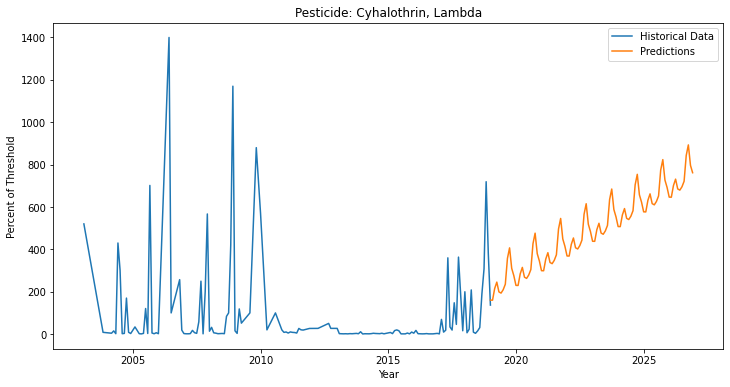

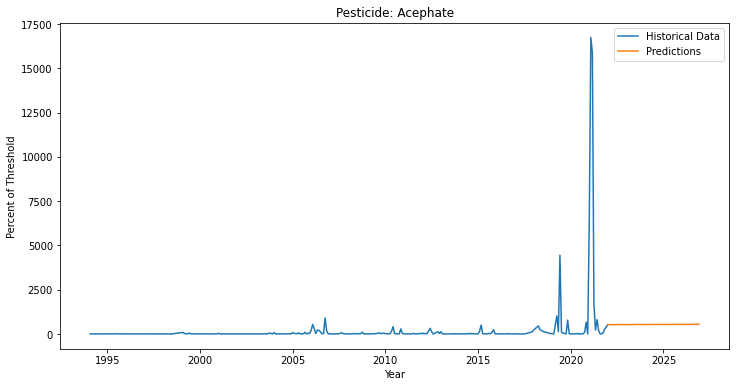

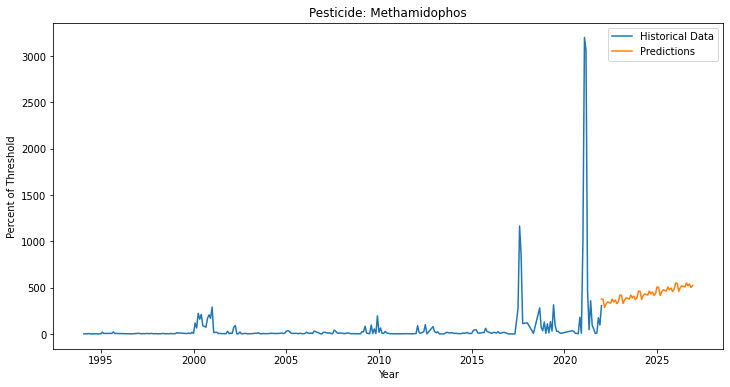

Average 'Percent of Threshold' for Cyhalothrin, Lambda between years 2025 to 2026: 733.37 %
Average 'Percent of Threshold' for Acephate between years 2025 to 2026: 543.05 %
Average 'Percent of Threshold' for Methamidophos between years 2025 to 2026: 519.3 %


In [17]:
def plot_pesticide_graph(pesticide, table, predictions):
    plt.figure(figsize=(12, 6))
    plt.plot(table['Year'] + table['Month'] / 12, table['Percent of Threshold'], label='Historical Data')
    
    if len(predictions) > 0:
        forecast_years = np.arange(table['Year'].max() + 1, end_year + 1)
        forecast_months = np.array([i % 12 + 1 for i in range(len(predictions))])
        forecast_years_months = np.array([(forecast_years[i // 12], m) for i, m in enumerate(forecast_months)])
        forecast_years_decimals = forecast_years_months[:, 0] + (forecast_years_months[:, 1] - 1) / 12
        
        plt.plot(forecast_years_decimals, predictions, label='Predictions')
    
    plt.title(f'Pesticide: {pesticide}')
    plt.xlabel('Year')
    plt.ylabel('Percent of Threshold')
    plt.legend()
    plt.show()

pesticide_averages = {}
for pesticide in unique_pesticides:
    if len(pesticide_predictions[pesticide]) > 0:
        last_12 = pesticide_predictions[pesticide][-12:]
        avg_last_12 = sum(last_12) / len(last_12)
        pesticide_averages[pesticide] = avg_last_12

highest_avg = 0
highest_pesticide = None
highest_pesticides = []
for pesticide, avg in pesticide_averages.items():
    if avg > highest_avg:
        highest_avg = avg
        highest_pesticide = pesticide
highest_pesticides.append(highest_pesticide)
highest_avg = 0
highest_pesticide = None
for pesticide, avg in pesticide_averages.items():
    if avg > highest_avg and pesticide not in highest_pesticides:
        highest_avg = avg
        highest_pesticide = pesticide
highest_pesticides.append(highest_pesticide)
highest_avg = 0
highest_pesticide = None
for pesticide, avg in pesticide_averages.items():
    if avg > highest_avg and pesticide not in highest_pesticides:
        highest_avg = avg
        highest_pesticide = pesticide
highest_pesticides.append(highest_pesticide)

if highest_pesticides:
    for highest_pesticide in highest_pesticides:
        highest_df = pesticide_tables[highest_pesticide]
        highest_forecast = pesticide_predictions[highest_pesticide]
    
        plot_pesticide_graph(highest_pesticide, highest_df, highest_forecast)
    
else:
    print("No pesticide with valid predictions was found.")

for i in highest_pesticides:
    print(f"Average 'Percent of Threshold' for",i,"between years 2025 to 2026:",round(pesticide_averages[i],2),"%")

## Analysis 2 (with completed data)

Plot 2: Pesticide with the top 3 highest average percent of the EPA threshold in the last 12 months (with complete data)  
   
Creates a plot similar to the first one but limits the data to those with only complete information.
Again, it shows the historical data and predictions using triple exponential smoothing for the pesticide with the highest average percentage of the EPA threshold in the last 12 months of predictions, using only the data with complete information. 

In [18]:
#Find pesticides with data from 1994 to 2021
pesticides_with_complete_data = []

for pesticide in unique_pesticides:
    temp_df = pesticide_tables[pesticide]
    min_year = temp_df['Year'].min()
    max_year = temp_df['Year'].max()
    if min_year == 1994 and max_year == 2021:
        pesticides_with_complete_data.append(pesticide)

#Print the list of pesticides with data from 1994 to 2021
#print("Pesticides with data from 1994 to 2021:")
#for pesticide in pesticides_with_complete_data:
#    print(pesticide)

In [19]:
#Define a function to predict the percent of threshold using triple exponential smoothing
def predict_threshold(data, end_year, end_month):
    model = ExponentialSmoothing(data['Percent of Threshold'],
                                 trend='add',
                                 seasonal='add',
                                 seasonal_periods=12)
    fit = model.fit()
    forecast_months = (end_year - data['Year'].max()) * 12 + end_month - data['Month'].max()
    forecast = fit.forecast(steps=forecast_months)
    return forecast

#Define the end year and month for predictions
end_year = 2026
end_month = 12

#Create a dictionary to store predictions for each pesticide
pesticide_predictions_with_complete_data = {}

#Loop through each pesticide table and make predictions
for pesticide in pesticides_with_complete_data:
    temp_df_with_complete_data = pesticide_tables[pesticide]
    try:
        forecast_with_complete_data = predict_threshold(temp_df_with_complete_data, end_year, end_month)
        pesticide_predictions_with_complete_data[pesticide] = forecast_with_complete_data
    except:
        # If the model cannot fit the data, save an empty list instead
        pesticide_predictions_with_complete_data[pesticide] = []

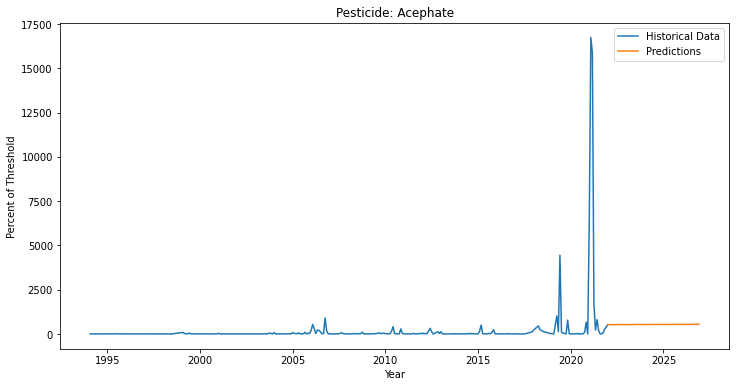

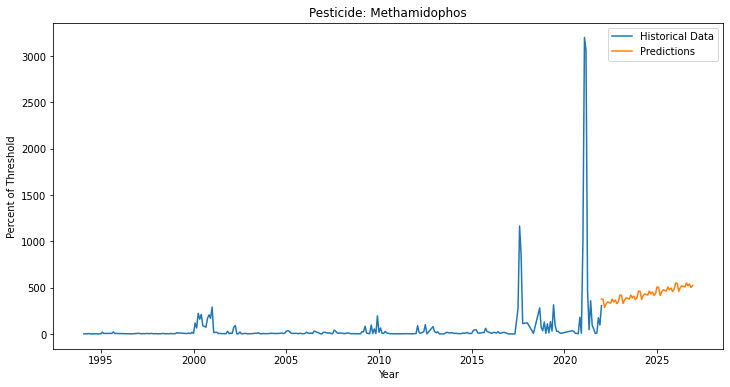

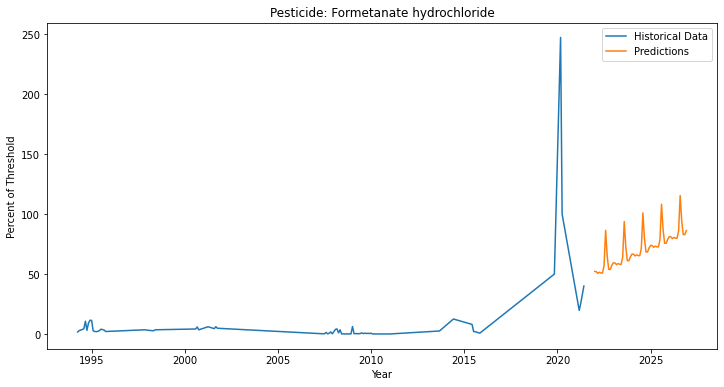

Average 'Percent of Threshold' for Acephate between years 2025 to 2026: 543.05 %
Average 'Percent of Threshold' for Methamidophos between years 2025 to 2026: 519.3 %
Average 'Percent of Threshold' for Formetanate hydrochloride between years 2025 to 2026: 85.9 %


In [20]:
def plot_pesticide_graph(pesticide, table, predictions):
    plt.figure(figsize=(12, 6))
    plt.plot(table['Year'] + table['Month'] / 12, table['Percent of Threshold'], label='Historical Data')
    
    if len(predictions) > 0:
        forecast_years = np.arange(table['Year'].max() + 1, end_year + 1)
        forecast_months = np.array([i % 12 + 1 for i in range(len(predictions))])
        forecast_years_months = np.array([(forecast_years[i // 12], m) for i, m in enumerate(forecast_months)])
        forecast_years_decimals = forecast_years_months[:, 0] + (forecast_years_months[:, 1] - 1) / 12
        
        plt.plot(forecast_years_decimals, predictions, label='Predictions')
    
    plt.title(f'Pesticide: {pesticide}')
    plt.xlabel('Year')
    plt.ylabel('Percent of Threshold')
    plt.legend()
    plt.show()

pesticide_averages_with_complete_data = {}
for pesticide in pesticides_with_complete_data:
    if len(pesticide_predictions_with_complete_data[pesticide]) > 0:
        last_12_with_complete_data = pesticide_predictions_with_complete_data[pesticide][-12:]
        avg_last_12_with_complete_data = sum(last_12_with_complete_data) / len(last_12_with_complete_data)
        pesticide_averages_with_complete_data[pesticide] = avg_last_12_with_complete_data

highest_avg_with_complete_data = 0
highest_pesticide_with_complete_data = None
highest_pesticide_with_complete_datas = []
for pesticide, avg in pesticide_averages_with_complete_data.items():
    if avg > highest_avg_with_complete_data:
        highest_avg_with_complete_data = avg
        highest_pesticide_with_complete_data = pesticide
highest_pesticide_with_complete_datas.append(highest_pesticide_with_complete_data)
highest_avg_with_complete_data = 0
highest_pesticide_with_complete_data = None
for pesticide, avg in pesticide_averages_with_complete_data.items():
    if avg > highest_avg_with_complete_data and pesticide not in highest_pesticide_with_complete_datas:
        highest_avg_with_complete_data = avg
        highest_pesticide_with_complete_data = pesticide
highest_pesticide_with_complete_datas.append(highest_pesticide_with_complete_data)
highest_avg_with_complete_data = 0
highest_pesticide_with_complete_data = None
for pesticide, avg in pesticide_averages_with_complete_data.items():
    if avg > highest_avg_with_complete_data and pesticide not in highest_pesticide_with_complete_datas:
        highest_avg_with_complete_data = avg
        highest_pesticide_with_complete_data = pesticide
highest_pesticide_with_complete_datas.append(highest_pesticide_with_complete_data)

if highest_pesticide_with_complete_datas:
    for highest_pesticide_with_complete_data in highest_pesticide_with_complete_datas:
        highest_df_with_complete_data = pesticide_tables[highest_pesticide_with_complete_data]
        highest_forecast_with_complete_data = pesticide_predictions_with_complete_data[highest_pesticide_with_complete_data]
    
        plot_pesticide_graph(highest_pesticide_with_complete_data, highest_df_with_complete_data, highest_forecast_with_complete_data)
    
else:
    print("No pesticide with valid predictions was found.")

for i in highest_pesticide_with_complete_datas:
    print(f"Average 'Percent of Threshold' for",i,"between years 2025 to 2026:",round(pesticide_averages_with_complete_data[i],2),"%")

## Report

#### Background Information

Pesticides play a crucial role in modern agriculture, protecting crops from pests and diseases, but they can also pose risks to human and animal health. The research question we are investigating is, "What pesticides will have the biggest impact on human and animal health in the next 3-5 years?" This is an important question as understanding the potential dangers of pesticide use can help inform regulations and policies to minimize their adverse effects on health and the environment. One way to evaluate the toxicity of pesticides is by looking at their LD50 values, which represent the dose required to kill 50% of a test population. A higher LD50 value means that the pesticide is less toxic, while a lower value indicates higher toxicity. 

#### Data Analysis Methodology

To answer the research question, we utilized the Pesticide Data Program (PDP) dataset from the US Department of Agriculture, which contains information on pesticide residues in food samples. We cleaned the dataset to include only relevant data, and then we calculated the "Percent of Threshold," which represents the ratio of the pesticide concentration in the sample to the EPA tolerance level. We then used a time series model called Triple Exponential Smoothing, which considers trends and seasonality in the data to predict the percent of the EPA tolerance threshold that pesticide concentrations would reach in the next 3-5 years. Finally, we calculated the average percent of the threshold for the final 12 months of the forecasted period (2025-2026). The pesticide with the top 3 highest average percent of the EPA tolerance threshold for the final 12 months of the forecasted period was plotted. Additionally, the same analysis was performed for the subset of pesticides with complete data from 1994 to 2021.   

#### Results

The pesticide with the top 3 highest average percent of the EPA tolerance threshold for the final 12 months of the forecasted period was:   
1. Cyhalothrin, Lambda: the average percent of threshold for this pesticide was 733.37%.   
2. Acephate: the average percent of threshold for this pesticide was 543.05%.   
3. Methamidophos: the average percent of threshold for this pesticide was 519.3%.   
   
The pesticide with the top 3 highest average percent of the EPA tolerance threshold for the final 12 months of the forecasted period among those with complete data from 1994 to 2021 was:   
1. Acephate: the average percent of threshold for this pesticide was 543.05%.   
2. Methamidophos: the average percent of threshold for this pesticide was 519.3%.    
3. Formetanate hydrochloride: the average percent of threshold for this pesticide was 85.9%.  
   
The percent of threshold represents the average amount of pesticide residue found on commodities. A higher percentage signifies a greater likelihood that the pesticide residues exceed the EPA threshold when ingested by humans and animals. Hence, Cyhalothrin, Lambda, Acephate, Methamidophos, and Formetanate hydrochloride ,the pesticides with the highest percent of threshold, will have the biggest impact on human and animal health in the next 3-5 years.   

#### Cyhalothrin, Lambda

Cyhalothrin, Lambda was identified as the most harmful pesticide among all the data, regardless of the completeness of the dataset. There is no data available for Cyhalothrin, Lambda before 2003 and after 2018, which might be due to its introduction to the market, changes in regulatory requirements, or updated safety guidelines led to reduced usage or the discontinuation of this particular pesticide. Our model predicts a concerning trend for Cyhalothrin, Lambda in the next 3-5 years, with an increase in its impact on human and animal health.   
   
Cyhalothrin, Lambda is a synthetic pyrethroid insecticide used to control a wide range of pests in agricultural and residential settings. It is effective against various insects, including ants, fleas, and mosquitoes. While it is considered less toxic to mammals than organophosphates like Acephate, it is still harmful, causing skin irritation, eye irritation, and nervous system effects in severe cases. It is also highly toxic to aquatic organisms and bees, which can have broader implications for the ecosystem.   

#### Analysis of Acephate

Acephate was identified as the most harmful pesticide among those with complete data from 1994 to 2021. Our analysis shows that there is a significant spike in the percent of threshold for Acephate in 2021. This increase might be attributed to changes in agricultural practices, increased pest resistance, or regulatory changes that allowed for higher application rates. However, comparing all the graphs we see that Methamidophos and Formetanate hydrochloride also potrays a spike during similar times. Hence, COVID-19 may be a large reason to this increase, as demands for global food supply drastically increased during this time.        
   
Acephate is an organophosphate insecticide used to control various pests in agricultural and non-agricultural settings. It is effective against a wide range of insects, such as aphids, caterpillars, and thrips. However, it is also toxic to humans and animals, causing symptoms like nausea, vomiting, diarrhea, and even seizures in severe cases. It can also have long-term effects on the nervous system. Moreover, it can have detrimental effects on aquatic life, birds, and beneficial insects, such as bees. In recent years, there have been concerns regarding the environmental impact of Acephate and its potential to contaminate water supplies.       

#### Analysis of Methamidophos

Spikes in the percentage of threshold for Methamidophos were observed in 2017 and 2021. The increase in 2017 could be attributed to factors such as changes in agricultural practices, increased pest resistance, or alterations in regulatory policies. The spike in 2020 may be related to the COVID-19 pandemic, which led to disruptions in the global food supply chain and heightened demand for increased crop production, resulting in greater pesticide usage.   
   
Methamidophos is a powerful organophosphate pesticide with insecticidal and acaricidal properties. It is widely used in agriculture to safeguard crops from harmful pests. However, it poses significant risks to human health and wildlife, causing severe neurological effects upon exposure. Methamidophos has also been linked to environmental contamination and can bioaccumulate in the food chain.   

#### Analysis of Formetanate hydrochloride

Formetanate Hydrochloride Analysis: A significant increase in the percentage of threshold for Formetanate hydrochloride occurred in 2020. This spike may be attributed to the COVID-19 pandemic, which caused disruptions in the agricultural industry and increased the reliance on certain pesticides to maintain crop yields. As a result, Formetanate hydrochloride usage might have surged due to its comparatively lower toxicity and the need to counteract the challenges posed by the pandemic.   
   
Formetanate Hydrochloride Overview: Formetanate hydrochloride is a carbamate-based pesticide known for its acaricidal and insecticidal properties. It is commonly used on fruit trees, vegetables, and ornamental plants to control mites and insects. Although less toxic than some other pesticides, it can still have negative effects on humans and the environment, particularly when used excessively or without proper safety measures.   

#### Limitations

The analysis conducted in this study has several limitations that should be considered when interpreting the results:   
   
a) Triple Exponential Smoothing Model: Although the triple exponential smoothing model is effective for capturing trend and seasonality, it may not be the best model for all pesticides' data. Some pesticides may exhibit different patterns or require more advanced models to accurately forecast their future impact on human and animal health.   
   
b) Pesticide Information: The analysis relies on historical data to make predictions about future trends, but there may be changes in the usage or regulations of pesticides that could significantly impact the results. For example, new bans or restrictions could be introduced, or new findings may emerge regarding the effects of certain pesticides on human and animal health. These developments could render the current analysis less accurate or obsolete.   
   
c) Data Completeness: The study assumes that the available data is representative of the actual pesticide usage and exposure. However, there might be missing data, underreporting, or other biases in the dataset that could influence the conclusions drawn from the analysis. Additionally, the study focuses on pesticides with complete data from 1994 to 2021, which might exclude other harmful pesticides from the analysis.   
   
d) External Factors: The analysis does not take into account other factors that may influence the impact of pesticides on human and animal health, such as environmental conditions, population growth, or changes in agricultural practices. These factors could have a significant impact on the actual risks posed by the identified pesticides in the future.   
   
e) Threshold Effects: The study focuses on the percentage of the EPA threshold for each pesticide, but it is worth noting that these thresholds are not definitive indicators of harm. Some pesticides may still have negative effects on human or animal health, even at levels below the EPA threshold, while others may not necessarily be harmful at levels slightly above the threshold.      

# 3.1 Which food products have pesticide residue levels that exceed FDA and EPA thresholds?  
- **Additional Info**: Which food products contain multiple pesticides which may or may not exceed regulatory thresholds that pose a greater health risk due to the variety of pesticides with different modes of action? What about commodities/pesticides specific to the USA?

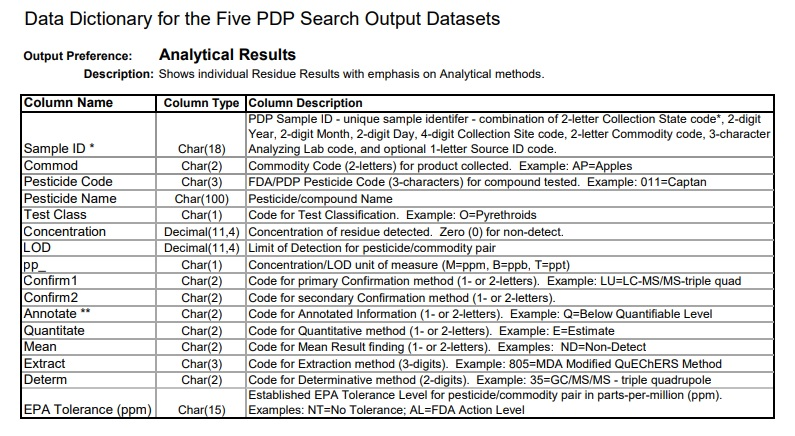

In [21]:
from IPython import display
display.Image("PDP_Review.jpg")

In [22]:
PDP_Data = pd.read_csv('PDP_Positive_Detects_1994-2021.csv',low_memory = False)

PDP_Data.head()

Sample ID Commod Pesticide Code  Pesticide Name Test Class  \
0  CA0307280363AACA1      AA            160    Chlorpyrifos          C   
1  CA0310280484AACA1      AA             83  O-Phenylphenol          I   
2  CA0311250391AACA1      AA             83  O-Phenylphenol          I   
3  FL0308220056AAFL1      AA            160    Chlorpyrifos          C   
4  MI0307280000AAFL1P     AA            160    Chlorpyrifos          C   

   Concentration     LOD pp_ Confirm 1 Confirm 2 Annotate Quantitate Mean  \
0         0.0250  0.0040   M         C         M      NaN          M    O   
1         0.0170  0.0100   M        MO       NaN       QV          H    O   
2         0.0170  0.0100   M        MO       NaN       QV          H    O   
3         0.0063  0.0038   M       NaN       NaN       Q           M    O   
4         0.0170  0.0038   M         D       NaN      NaN          M    O   

  Extract  Determ EPA Tolerance (ppm)  
0     552     2.0                   5  
1     550     7.0                  NT  
2     550     7.0                  NT  
3     802    60.0                   5  
4     551    60.0                   5

**Because the EPA tolerance is measured in Parts Per Million (PPM) we need to covert the values in the Concentration column by the type in the pp_ column, such that they're all in this unit form:**


In [23]:
# They can be M = PPM, B = PPB, and T = PPT, let's check unique vals:
print("Unique Tolerances:",PDP_Data["pp_"].unique())

Unique Tolerances: ['M' 'T']


In [24]:
# First we need to create a method to convert the data:
# ppt to ppm is 1 to 0.000001, so xppm = xppt / 10^6
def ppt_to_ppm(data_col):
    """
    Converts PPT to PPM
    """
    ppm = []
    for i in data_col:
        ppm.append(i/0.000001)
    return ppm

# Since we only have PPM (What we need) and PPT, we convert all PPT values:
# If the pp_ column contains T instead of M, convert it, otherwise, stay the same.
PDP_Data['PPM'] = np.where(PDP_Data["pp_"].str.contains('T', regex=False), 
                           ppt_to_ppm(PDP_Data["Concentration"]), PDP_Data["Concentration"])

PDP_Data["PPM"] # Check column added.

0         0.0250
1         0.0170
2         0.0170
3         0.0063
4         0.0170
           ...  
571217    0.0110
571218    0.0025
571219    0.0570
571220    0.0025
571221    0.0025
Name: PPM, Length: 571222, dtype: float64

**Now lets work on finding the commodities with concentraion (ppm) that exceeds the EPA Tolerance levels:**

In [25]:
PDP_Data.head() # New PPM Concentraion column added

Sample ID Commod Pesticide Code  Pesticide Name Test Class  \
0  CA0307280363AACA1      AA            160    Chlorpyrifos          C   
1  CA0310280484AACA1      AA             83  O-Phenylphenol          I   
2  CA0311250391AACA1      AA             83  O-Phenylphenol          I   
3  FL0308220056AAFL1      AA            160    Chlorpyrifos          C   
4  MI0307280000AAFL1P     AA            160    Chlorpyrifos          C   

   Concentration     LOD pp_ Confirm 1 Confirm 2 Annotate Quantitate Mean  \
0         0.0250  0.0040   M         C         M      NaN          M    O   
1         0.0170  0.0100   M        MO       NaN       QV          H    O   
2         0.0170  0.0100   M        MO       NaN       QV          H    O   
3         0.0063  0.0038   M       NaN       NaN       Q           M    O   
4         0.0170  0.0038   M         D       NaN      NaN          M    O   

  Extract  Determ EPA Tolerance (ppm)     PPM  
0     552     2.0                   5  0.0250  
1     550     7.0                  NT  0.0170  
2     550     7.0                  NT  0.0170  
3     802    60.0                   5  0.0063  
4     551    60.0                   5  0.0170

In [26]:
# How many commodities in the data?
print("Unique Commodities:",len(PDP_Data["Commod"].unique()))

Unique Commodities: 129


**The EPA Column is in char format because it contains many different thresholds, all in ppm, for the tolerances. Because of this, we need to extract the numerical values from this column to compare to the PPM column for each commodity.**

In [27]:
print("Unique EPA Tolerance Values:",PDP_Data["EPA Tolerance (ppm)"].unique())

Unique EPA Tolerance Values: ['5' 'NT' '0.6' '10' '25' '1.5' '1' '0.3' '3' '2' '1.7' '15' '1.2' '12'
 '0.5' '0.1' '7' '4' '0.8' '0.02' '0.2' '0.4' '0.75' '0.05' '14' '10.0 PP'
 '5.0 PH' '25.0 TP' '2.0 TP' '8' '0.1 AL' '0.7' '0.25' '0.03 AL' '0.15'
 '0.01' '0.5 AL' '13' '0.04' '5.0 R' '15 TP' '2.5' '1.6' '1.8' '5 AL'
 '0.3 AL' '0.2 AL' '7 AL' '3.5' '6' '20' '0.9' '0.1 FF' '20.0 TP'
 '0.01 FF' '0.30 TP' '1.3' '1.0 TP' '1.0 FU' '3.0 TP' '4.0 PH' '3.0 PH'
 '0.1 EP' '0.5 FU' '2.0 FU' '0.40 IM' '10 FU' '3.0 FU' '0.2 FU' '1.4' '30'
 '4.5' '1.9' '9' '4.5 TP' '10 FF' '1 AL' '0.03' '50' '0.05 FF' '0.02 TP'
 '40' '0.02 FF' '150' '90' '400' '5.0 IN' '200' '80' '5.0 FF' '100'
 '1.25 AL' '6.25' '85' '0.015' '22' 'EX' '45' '29' '60' '35' '0.5 R'
 '10 TP' '11' 'EX3' '0.03 IN' '4.0 TP' '0.08' '21' '5 FF' 'NR' '15.0 FU'
 '0.2 TP' '10 EP' '15.0 PH' '10 PH' '0.02 AL' '0.09' '0.01 AL' '8 PH'
 '3 AL' '0.45' '3.0 AL' '10.0 PH' '0.05 AL' '0.06' '0.25 TP' '5.0 TP' nan
 '20 IT' '2.0 IN' '0.05 TP' '2.0 IT' '2.0 

**Extracting the numeric values from the EPA Tolerance Column for comparison to PPM Column:**
- While replacing No Tolerance values or non-numeric thresholds with NAN in the EPA columns as well.

In [28]:
EPA = list(PDP_Data["EPA Tolerance (ppm)"])
numbers = []
for i in EPA:
    if isinstance(i,str):
        # Find number or decimal in the column, exlude nan or otherwise:
        match = re.findall(r'\d+(?:\.\d+)?', i)
        if len(match) == 1:
            numbers.append(float(match[0]))
        elif len(match) == 2:
            numbers.append(float(match[0])/float(match[1]))
        else:
            numbers.append(np.nan)
    else:
        numbers.append(np.nan)
        
print(len(numbers))
print(len(EPA)) # Should be same lengths! 

print(EPA[0:10])
print(numbers[0:10])

571222
571222
['5', 'NT', 'NT', '5', '5', '5', '5', '5', 'NT', '0.6']
[5.0, nan, nan, 5.0, 5.0, 5.0, 5.0, 5.0, nan, 0.6]


**Now we need to remove columns where the EPA tolerance is missing, we don't want to estimate by average for the commodities EPA tolerance because this is different for every item, and assigned by the FDA.**

Values can be NT = No Tolerance, or AL = Action Level (Threshold) All values will be measured in PPM. They were all replaced by np.nan in the previous block of code.

In [29]:
PDP_Data["New EPA"] = numbers
PDP_Data["New EPA"]

0          5.0
1          NaN
2          NaN
3          5.0
4          5.0
          ... 
571217     NaN
571218    10.0
571219     NaN
571220    10.0
571221    10.0
Name: New EPA, Length: 571222, dtype: float64

In [30]:
PDP_Data = PDP_Data.dropna(subset=["New EPA"])
PDP_Data["New EPA"]

0          5.0
3          5.0
4          5.0
5          5.0
6          5.0
          ... 
571213     0.5
571215    10.0
571218    10.0
571220    10.0
571221    10.0
Name: New EPA, Length: 487446, dtype: float64

### Finally we can do the PPM column comparison to the New EPA thresholds converted column:

In [31]:
# Extract columns where PPM greater than New EPA Value
Exceeds_Threshold = PDP_Data[PDP_Data.PPM.gt(PDP_Data["New EPA"])]
Exceeds_Threshold.head()

Sample ID Commod Pesticide Code    Pesticide Name Test Class  \
12042  CA0902180429APCA1      AP            160      Chlorpyrifos          C   
12333  CA0907220473APCA1      AP            157     Thiabendazole          B   
12426  CA0909010473APCA1      AP            157     Thiabendazole          B   
20145  FL9507130001APTX1      AP            539  Permethrin Total          O   
21422  MD1008110028APNY1      AP            157     Thiabendazole          B   

       Concentration     LOD pp_ Confirm 1 Confirm 2 Annotate Quantitate Mean  \
12042          0.145  0.0021   M         C       NaN      NaN        NaN    O   
12333          5.900  0.0030   M        LU       NaN        X        NaN    O   
12426          5.700  0.0030   M        LU       NaN        X        NaN    O   
20145          0.142  0.0110   M         D         M        X          H    A   
21422          7.400  0.0010   M        LU       NaN        X        NaN    O   

      Extract  Determ EPA Tolerance (ppm)    PPM  New EPA  
12042     805     2.0                 0.1  0.145     0.10  
12333     805    52.0                   5  5.900     5.00  
12426     805    52.0                   5  5.700     5.00  
20145     NaN     NaN                0.05  0.142     0.05  
21422     806    52.0                   5  7.400     5.00

### Plotting Exceeding Threshold Results

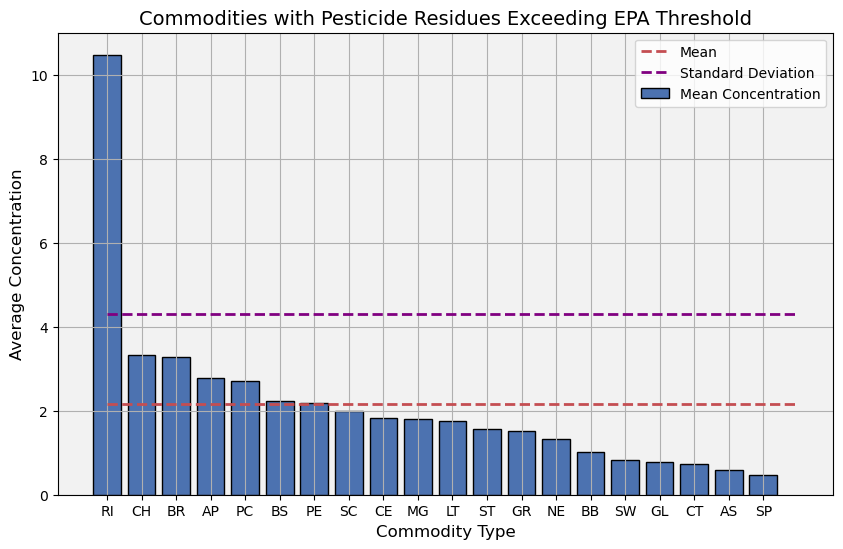

In [32]:
Commod_EPA = Exceeds_Threshold.groupby('Commod', as_index=False)['Concentration'].mean()
Commod_EPA_sorted = Commod_EPA.sort_values(by='Concentration', ascending=False).head(20)

concentration_mean = Commod_EPA_sorted['Concentration'].mean()
concentration_std = Commod_EPA_sorted['Concentration'].std()

with plt.style.context({'axes.edgecolor':'black'}):
    fig, ax = plt.subplots(figsize=(10,6))

    ax.bar(Commod_EPA_sorted['Commod'], Commod_EPA_sorted['Concentration'], color='#4C72B0', edgecolor='black', label='Mean Concentration')
    ax.plot([0, len(Commod_EPA_sorted)], [concentration_mean, concentration_mean], color='#C44E52', linestyle='--', linewidth=2, label='Mean')
    ax.plot([0, len(Commod_EPA_sorted)], [concentration_mean + concentration_std, concentration_mean + concentration_std], color='purple', linestyle='--', linewidth=2,label='Standard Deviation')

    ax.set_xlabel('Commodity Type', fontsize=12)
    ax.set_ylabel('Average Concentration', fontsize=12)
    ax.set_title('Commodities with Pesticide Residues Exceeding EPA Threshold', fontsize=14)
    ax.grid(True)

    ax.set_facecolor('#F2F2F2')
    ax.legend(frameon=True, fontsize=10)

plt.show()


After pulling only the commodities with pesticides exceeding the EPA Threshold, we noticed there were far more commodities than expected that met this criteria, so we pulled the top 20, and display the mean concentration including the standard deviation in the plot.

Adding a line for one standard deviation below the mean, and a standard deviation line above the mean helps us visualize the spread of the data around the mean concentration value. We can see that for these 20 commodities over the EPA limit, the item **RICE** is above the the upper bound for STD, meaning the concentration is farther away from the mean than what is expected based on the normal distribution assumption, considered as an outlier in the data. 

The commodities, **CHERRIES, BROCCOLI, APPLES,PEACHES, and BASIL** fall just above the average concentration level. 

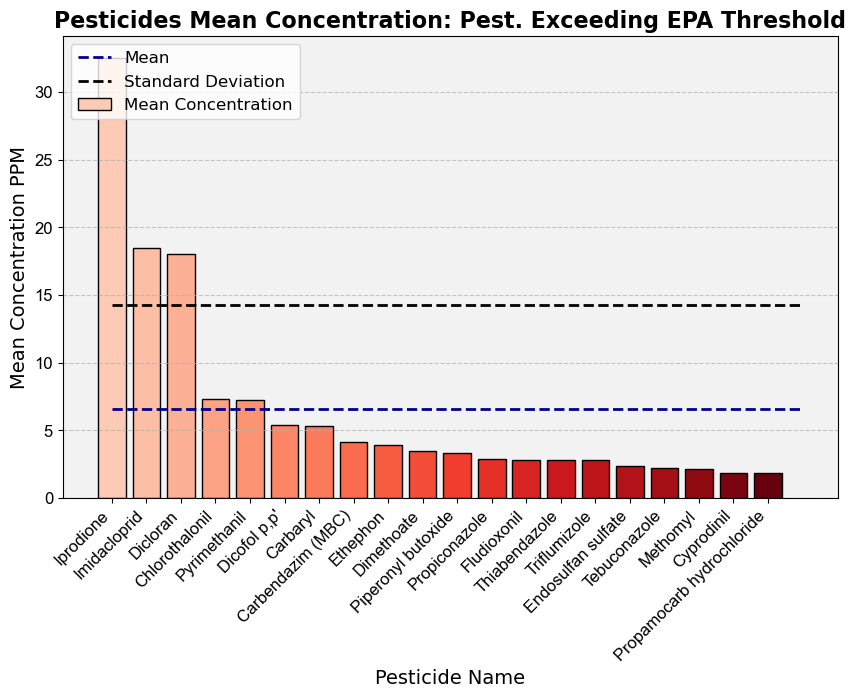

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Define data
Pest_EPA = Exceeds_Threshold.groupby('Pesticide Name', as_index=False)['Concentration'].mean()
Pest_EPA_sorted = Pest_EPA.sort_values(by='Concentration', ascending=False).head(20)

pest_mean = Pest_EPA_sorted['Concentration'].mean()
pest_std = Pest_EPA_sorted['Concentration'].std()

# Set plot size
plt.figure(figsize=(10, 6))

# Define color scheme
colors = plt.cm.Reds(np.linspace(0.2, 1, len(Pest_EPA_sorted)))

# Create bar chart
plt.bar(Pest_EPA_sorted['Pesticide Name'], Pest_EPA_sorted['Concentration'], color=colors, edgecolor='black', label='Mean Concentration')

# Add horizontal grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set axis labels and title
plt.xlabel('Pesticide Name', fontsize=14)
plt.ylabel('Mean Concentration PPM', fontsize=14)
plt.title('Pesticides Mean Concentration: Pest. Exceeding EPA Threshold', fontsize=16, fontweight='bold')

# Set font size for tick labels
plt.xticks(rotation=45, ha='right', fontsize=12, fontname='Arial')
plt.yticks(fontsize=12, fontname='Arial')

# Add mean and standard deviation lines
plt.plot([0, len(Pest_EPA_sorted)], [pest_mean, pest_mean], color='darkblue', linestyle='--', linewidth=2, label='Mean')
plt.plot([0, len(Pest_EPA_sorted)], [pest_mean + pest_std, pest_mean + pest_std], color='black', linestyle='--', linewidth=2, label='Standard Deviation')

# Add legend
plt.legend(fontsize=12, loc='upper left')

# Set background color
ax = plt.gca()
ax.set_facecolor('#f2f2f2')

# Show plot
plt.show()




The mean line can help provide a quick visual reference for where the average concentration falls relative to the other pesticides, and can also help in comparing the concentration of individual pesticides to the average concentration of all the pesticides. We can see here, using the upper bound of the STD, that the pesticides **IPRODIONE, IMIDACLOPRID, and DICLORAN** all fall above the normal distribution upper bound, and both **PYRIMETHANIL and DICOFOL** are above the average concentration.

# 3.2 Dirty Dozen Data 


**Our sponsor provided us with a news article:** https://www.miamiherald.com/news/nation-world/national/article260221880.html
Regarding the foods that most often test positive for high pesticide residue levels, this is the research regarding these 12 commodities.

**This code focuses on the concentration levels of these "Dirty Dozen" commodities.**

In [37]:
PDP_Data = pd.read_csv('PDP_Positive_Detects_1994-2021.csv',low_memory = False)
PDP_Data.head()

# Pulling top 12, Strawberries, Spinach, Kale, Celery, Apple, Nectarine, Grape, Peppers, Cherry, Pear, Tomato, Peach:
# AP = APPLES, ST = STRAWBERRIES, TO = TOMATOES, PE = Pears, NE = NECTARINES, SP = SPINACH,CH = CHERRIES,
# GR = GRAPES, GK = KALE GREENS, PC = PEACHES, HP = HOT PEPPERS, CE = CELERY

P_12 = ["AP","ST", "TO", "PE","NE", "SP","CH","GR", "GK", "PC","HP", "CE"]

In [38]:
# Extracting Dirty Dozen
Top_12 = PDP_Data[PDP_Data["Commod"].isin(P_12)]
Top_12.head()

Sample ID Commod Pesticide Code       Pesticide Name  \
10439  CA0010230004APWA1      AP            125  Diphenylamine (DPA)   
10440  CA0010230004APWA1      AP            157        Thiabendazole   
10441  CA0010230069APWA1      AP             42      Azinphos methyl   
10442  CA0010230069APWA1      AP            160         Chlorpyrifos   
10443  CA0010230091APWA1      AP             42      Azinphos methyl   

      Test Class  Concentration    LOD pp_ Confirm 1 Confirm 2 Annotate  \
10439          F          2.100  0.025   M        MO       NaN      NaN   
10440          B          1.000  0.030   M         M       NaN      NaN   
10441          C          0.100  0.011   M         D         M      NaN   
10442          C          0.043  0.004   M         D         M      NaN   
10443          C          0.044  0.011   M         D         M      NaN   

      Quantitate Mean Extract  Determ EPA Tolerance (ppm)  
10439          M    O     552     7.0                  10  
10440          M    O     552    15.0                  10  
10441          M    O     552     2.0                 1.5  
10442          M    O     552     1.0                 1.5  
10443          M    O     552     2.0                 1.5

**Spinach, Kale, and Peaches have highest concentration of dirty dozen!**

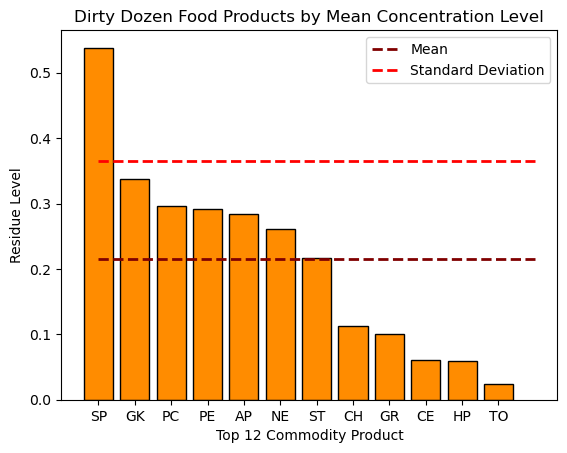

In [39]:
Top_12_Conc = Top_12.groupby('Commod', as_index=False)['Concentration'].mean()
Top_12_Conc = Top_12_Conc.sort_values(by='Concentration', ascending=False)

# Calculate mean and standard deviation
conc_mean = Top_12_Conc['Concentration'].mean()
conc_std = Top_12_Conc['Concentration'].std()

# Create bar chart of mean residue levels by dirty dozen product
plt.figure()
plt.bar(Top_12_Conc["Commod"], Top_12_Conc["Concentration"], color = "darkorange",edgecolor = "black")
plt.plot([0, len(Top_12_Conc)], [conc_mean, conc_mean], color='maroon', linestyle='--', linewidth=2, label='Mean')
plt.plot([0, len(Top_12_Conc)], [conc_mean + conc_std, conc_mean + conc_std], color='red', linestyle='--', linewidth=2, label='Standard Deviation')
plt.title('Dirty Dozen Food Products by Mean Concentration Level')
plt.xlabel('Top 12 Commodity Product')
plt.ylabel('Residue Level')
plt.legend()
plt.show()

**Spinach is far above STD, while Kale, Peaches, Pears, Apples, Nectarines, and Strawberries fall above the average concentration.**

# 4. Are there trends in pesticide residue levels on foods over time, by food product, by location, by quantity (tonnage) of pesticides manufactured, by pesticide toxicity or environmental impact, by pesticide class that could be used to predict issues with certain foods?

In order to perform the necessary analysis to answer this series of questions, some pre-processing and feature engineering is required to get the data in the proper format. This includes adding necessary columns, standardizing units and cleaning relevant columns.

## 4.1: Pre-processing Data / Feature Engineering

### Create "State" column

In [7]:
df = pd.read_csv('PDP_Positive_Detects_1994-2021.csv',low_memory = False)


states = []

# Iterate through each row in the dataframe and extract the date from the "PDP Sample ID" column
for i in range(len(df)):
    sample_id = df.loc[i, "Sample ID"]
    state = sample_id[0:2]
    state_code = f"{state}"  # Assumes year is in the 21st century
    states.append(state_code)

# Add the list of dates as a new column "Date" to the dataframe
df["State"] = states

# Print the first 5 rows of the dataframe to verify that the "Date" column was added correctly
df['State'].head()

0    CA
1    CA
2    CA
3    FL
4    MI
Name: State, dtype: object

### Create "Date" column

In [8]:
# Create an empty list to store the extracted dates
dates = []

# Iterate through each row in the dataframe and extract the date from the "PDP Sample ID" column
for i in range(len(df)):
    sample_id = df.loc[i, "Sample ID"]
    year = sample_id[2:4]
    month = sample_id[4:6]
    day = sample_id[6:8]
    date = f"{year}-{month}-{day}"  # Assumes year is in the 21st century
    dates.append(date)

# Add the list of dates as a new column "Date" to the dataframe
df["Date"] = dates
df['Date'].head()

0    03-07-28
1    03-10-28
2    03-11-25
3    03-08-22
4    03-07-28
Name: Date, dtype: object

### Create "Year" Column

In [9]:
def get_year_century(date_str):
    year = int(date_str[:2])
    if year > 21:
        century_prefix = '19'
    else:
        century_prefix = '20'
    return int(century_prefix + date_str[:2])

# Create "Year" column using the get_year_century function
df['Year'] = df['Date'].apply(get_year_century)

# Print the updated dataframe
df['Year'].unique()

array([2003, 2010, 2002, 2006, 2016, 2017, 2007, 2008, 2012, 2013, 2020,
       1996, 1997, 1998, 2000, 2001, 2004, 2005, 2009, 2014, 2015, 1994,
       1995, 1999, 2018, 2019, 2021, 2011], dtype=int64)

### Convert units that are in ppt (parts per trillion) to ppm (parts per million)

In [10]:
def ppt_to_ppm(data_col):
    """
    Converts PPT to PPM
    """
    ppm = []
    for i in data_col:
        ppm.append(i/0.000001)
    return ppm

# Since we only have PPM (What we need) and PPT, we convert all PPT values:
# If the pp_ column contains T instead of M, convert it, otherwise, stay the same.
df['PPM'] = np.where(df["pp_"].str.contains('T', regex=False), 
                           ppt_to_ppm(df["Concentration"]), df["Concentration"])

df.head() # Check column added.

Sample ID Commod Pesticide Code  Pesticide Name Test Class  \
0  CA0307280363AACA1      AA            160    Chlorpyrifos          C   
1  CA0310280484AACA1      AA             83  O-Phenylphenol          I   
2  CA0311250391AACA1      AA             83  O-Phenylphenol          I   
3  FL0308220056AAFL1      AA            160    Chlorpyrifos          C   
4  MI0307280000AAFL1P     AA            160    Chlorpyrifos          C   

   Concentration     LOD pp_ Confirm 1 Confirm 2 Annotate Quantitate Mean  \
0         0.0250  0.0040   M         C         M      NaN          M    O   
1         0.0170  0.0100   M        MO       NaN       QV          H    O   
2         0.0170  0.0100   M        MO       NaN       QV          H    O   
3         0.0063  0.0038   M       NaN       NaN       Q           M    O   
4         0.0170  0.0038   M         D       NaN      NaN          M    O   

  Extract  Determ EPA Tolerance (ppm) State      Date  Year     PPM  
0     552     2.0                   5    CA  03-07-28  2003  0.0250  
1     550     7.0                  NT    CA  03-10-28  2003  0.0170  
2     550     7.0                  NT    CA  03-11-25  2003  0.0170  
3     802    60.0                   5    FL  03-08-22  2003  0.0063  
4     551    60.0                   5    MI  03-07-28  2003  0.0170

### Create clean EPA threshold column

In [11]:
EPA = list(df["EPA Tolerance (ppm)"])
numbers = []
for i in EPA:
    if isinstance(i,str):
        # Find number or decimal in the column, exlude nan or otherwise:
        match = re.findall(r'\d+(?:\.\d+)?', i)
        if len(match) == 1:
            numbers.append(float(match[0]))
        elif len(match) == 2:
            numbers.append(float(match[0])/float(match[1]))
        else:
            numbers.append(np.nan)
    else:
        numbers.append(np.nan)
        
print(len(numbers))
print(len(EPA)) # Should be same lengths! 

print(EPA[0:10])
print(numbers[0:10])

571222
571222
['5', 'NT', 'NT', '5', '5', '5', '5', '5', 'NT', '0.6']
[5.0, nan, nan, 5.0, 5.0, 5.0, 5.0, 5.0, nan, 0.6]


In [12]:
df["New EPA"] = numbers
df = df.dropna(subset=['New EPA'])

### Create "Percent of Threshold" column

In [13]:
df['Percent of Threshold'] = (df['Concentration'] / df['New EPA']) * 100
df.head()

Sample ID Commod Pesticide Code Pesticide Name Test Class  \
0  CA0307280363AACA1      AA            160   Chlorpyrifos          C   
3  FL0308220056AAFL1      AA            160   Chlorpyrifos          C   
4  MI0307280000AAFL1P     AA            160   Chlorpyrifos          C   
5  NY0307300009AAFL1      AA            160   Chlorpyrifos          C   
6  NY0307300228AAFL1      AA            160   Chlorpyrifos          C   

   Concentration     LOD pp_ Confirm 1 Confirm 2  ... Mean Extract Determ  \
0         0.0250  0.0040   M         C         M  ...    O     552    2.0   
3         0.0063  0.0038   M       NaN       NaN  ...    O     802   60.0   
4         0.0170  0.0038   M         D       NaN  ...    O     551   60.0   
5         0.0063  0.0038   M         D       NaN  ...    O     551    2.0   
6         0.0063  0.0038   M         D       NaN  ...    O     551    2.0   

  EPA Tolerance (ppm)  State      Date  Year     PPM  New EPA  \
0                   5     CA  03-07-28  2003  0.0250      5.0   
3                   5     FL  03-08-22  2003  0.0063      5.0   
4                   5     MI  03-07-28  2003  0.0170      5.0   
5                   5     NY  03-07-30  2003  0.0063      5.0   
6                   5     NY  03-07-30  2003  0.0063      5.0   

   Percent of Threshold  
0                 0.500  
3                 0.126  
4                 0.340  
5                 0.126  
6                 0.126  

[5 rows x 22 columns]

## 4.2: Figures

The goal of this section is to provide information visually which show general trends in the data.

### Mean Residue Levels Over Time

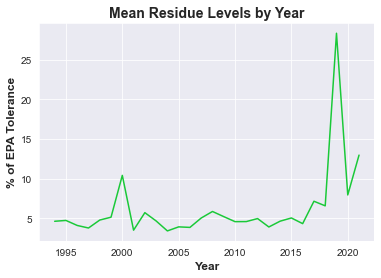

In [14]:
# Set style and color palette
sns.set_style("darkgrid")
sns.set_palette(sns.color_palette("bright", n_colors=5)[2:3])

# Create time series plot of mean residue levels by year
residue_by_year = df.groupby('Year')['Percent of Threshold'].mean()

# Mean residue levels plot with standard deviation line
sns.lineplot(x=residue_by_year.index, y=residue_by_year.values)

plt.title('Mean Residue Levels by Year', fontweight='bold', fontsize=14)
plt.xlabel('Year', fontweight='bold', fontsize=12)
plt.ylabel('% of EPA Tolerance', fontweight='bold', fontsize=12)

# Show plot
plt.show()

The percent of EPA tolerance appears to be in acceptable ranges all the way up until 2017-2018 when it jumps up drastically. In order to better see what is going on, we will subset the data to only 2018 forward.

In [15]:
mean_residue_2018_2021 = df[df['Year'] >= 2018]
mean_residue_2018_2021.describe()

Concentration           LOD        Determ          Year           PPM  \
count   87239.000000  87239.000000  87239.000000  87239.000000  87239.000000   
mean        0.116007      0.005167     50.179587   2019.573035      0.116007   
std         0.681719      0.008925     12.536553      1.158937      0.681719   
min         0.001000      0.001000     35.000000   2018.000000      0.001000   
25%         0.004700      0.001200     35.000000   2019.000000      0.004700   
50%         0.013000      0.002500     52.000000   2020.000000      0.013000   
75%         0.045400      0.005000     52.000000   2021.000000      0.045400   
max       105.000000      0.200000     80.000000   2021.000000    105.000000   

            New EPA  Percent of Threshold  
count  87239.000000          87239.000000  
mean       7.152360             13.773066  
std       19.197007            602.864562  
min        0.010000              0.000750  
25%        0.800000              0.190000  
50%        3.000000              0.780000  
75%        7.000000              2.636667  
max      400.000000         140000.000000

We can see from the summary statistics that the mean is 13.77 but the standard deviation is 602.86, which indicates some very high values that are distorting the results.

### Top 10 Highest Mean Residue Levels by Food Commodity

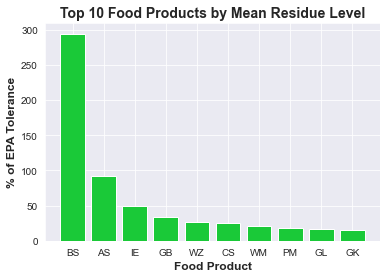

In [16]:
# Create bar chart of mean residue levels by food product
residue_by_product = df.groupby('Commod')['Percent of Threshold'].mean()
residue_by_product = residue_by_product.sort_values(ascending=False).head(10)
plt.figure()
plt.bar(residue_by_product.index, residue_by_product.values)
plt.title('Top 10 Food Products by Mean Residue Level', fontweight='bold', fontsize=14)
plt.xlabel('Food Product', fontweight='bold', fontsize=12)
plt.ylabel('% of EPA Tolerance', fontweight='bold', fontsize=12)

# Show plot
plt.show()

From this figure we can see that the commodity 'BS' which stands for Basil is almost 300% of the EPA threshold. This warrants taking a closer look at that particular data to identify the cause.

In [17]:
BS_data = df[df['Commod'] == 'BS']
BS_data.describe()

Concentration          LOD       Determ    Year          PPM  \
count    1598.000000  1598.000000  1598.000000  1598.0  1598.000000   
mean        0.951636     0.002656    53.951189  2019.0     0.951636   
std         3.784038     0.004072    17.566230     0.0     3.784038   
min         0.001700     0.001000    35.000000  2019.0     0.001700   
25%         0.005700     0.001000    35.000000  2019.0     0.005700   
50%         0.038000     0.001500    52.000000  2019.0     0.038000   
75%         0.425000     0.003000    80.000000  2019.0     0.425000   
max       105.000000     0.075000    80.000000  2019.0   105.000000   

           New EPA  Percent of Threshold  
count  1598.000000           1598.000000  
mean     50.788536            294.255672  
std      98.156704           3837.233047  
min       0.010000              0.000750  
25%       3.000000              0.040278  
50%      10.000000              0.700000  
75%      50.000000              8.000000  
max     400.000000         140000.000000

From the summary statistics of all rows of data for the Basil commodity we can see that the mean value is 294.26 whereas the standard deviation is 3837.23. This indicates a lot of variability in the data and tells us that the data for basil is spread out across a wide range. The max value for the 'Percent of Threshold' column is 140000, or 140,000% of the EPA Threshold. This is unbelievably concerning. Let's look closer at this value.

In [18]:
BS_exceeds = BS_data[BS_data['Percent of Threshold'] > 100]
BS_exceeds.describe()

Concentration         LOD      Determ    Year         PPM     New EPA  \
count     159.000000  159.000000  159.000000   159.0  159.000000  159.000000   
mean        2.241365    0.007058   45.987421  2019.0    2.241365    0.483459   
std        10.313411    0.010640   17.255338     0.0   10.313411    1.847097   
min         0.011000    0.001000   35.000000  2019.0    0.011000    0.010000   
25%         0.078000    0.001000   35.000000  2019.0    0.078000    0.010000   
50%         0.250000    0.003000   35.000000  2019.0    0.250000    0.050000   
75%         0.795000    0.007500   52.000000  2019.0    0.795000    0.050000   
max       105.000000    0.075000   80.000000  2019.0  105.000000    8.000000   

       Percent of Threshold  
count            159.000000  
mean            2903.720126  
std            11883.447977  
min              105.000000  
25%              260.000000  
50%              690.000000  
75%             2200.000000  
max           140000.000000

There is still a large degree of variability in the data and there are 159 cases of pesticides associated with basil that are over their EPA threshold. The most extreme casse are presented below.

In [19]:
BS_exceeds[BS_exceeds['Percent of Threshold'] >= 10000]

Sample ID Commod Pesticide Code  \
65473  CA1908070569BSNY1      BS            AEL   
65741  FL1905130060BSNY1P     BS            204   
65901  FL1908120084BSNY1      BS            B80   
65948  FL1909090087BSNY1Y     BS            B80   
66514  NY1906040142BSNY1      BS            B80   
66628  NY1907020258BSNY1      BS            AEL   

                                          Pesticide Name Test Class  \
65473  Cyhalothrin, Total (Cyhalothrin-L + R157836 ep...          O   
65741                                           Acephate          C   
65901                                        Acetamiprid          A   
65948                                        Acetamiprid          A   
66514                                        Acetamiprid          A   
66628  Cyhalothrin, Total (Cyhalothrin-L + R157836 ep...          O   

       Concentration    LOD pp_ Confirm 1 Confirm 2  ... Mean Extract Determ  \
65473            1.1  0.003   M        GT       NaN  ...    O     805   35.0   
65741            6.2  0.005   M        LU       NaN  ...    O     805   52.0   
65901            4.4  0.003   M        HR       NaN  ...    O     805   80.0   
65948           14.0  0.003   M        HR       NaN  ...    O     805   80.0   
66514            1.1  0.003   M        LU       NaN  ...    O     805   52.0   
66628            1.4  0.003   M        GT       NaN  ...    O     805   35.0   

      EPA Tolerance (ppm)  State      Date  Year   PPM  New EPA  \
65473             0.01 FF     CA  19-08-07  2019   1.1     0.01   
65741             0.02 FF     FL  19-05-13  2019   6.2     0.02   
65901             0.01 FF     FL  19-08-12  2019   4.4     0.01   
65948             0.01 FF     FL  19-09-09  2019  14.0     0.01   
66514             0.01 FF     NY  19-06-04  2019   1.1     0.01   
66628             0.01 FF     NY  19-07-02  2019   1.4     0.01   

       Percent of Threshold  
65473               11000.0  
65741               31000.0  
65901               44000.0  
65948              140000.0  
66514               11000.0  
66628               14000.0  

[6 rows x 22 columns]

These six rows show pesticides associated with basil which are over 1000% of their EPA threshold. We can see that 3 of the 6 are Acetamiprid, 2 are Cyhalothrin and 1 is Acephate. These chemicals are generally considered Class II pesticides by the EPA which indicates they are moderately toxic and can still pose a significant risk of harm. Because of this, Acetamiprid, Acephate and Cyhalothrin should be investigated in their use when it comes to basil and other food commodities. It is also worth noting that all 6 of these abnormally large concentrations occurred in 2019. This is reflective of our mean pesticide residue levels jumping up drastically around 2018-19.

### Top 10 Highest States by Mean Residue Level

In [20]:
# Create bar chart of mean residue levels by location
residue_by_location = df.groupby('State')['Percent of Threshold'].mean()
residue_by_location = residue_by_location.sort_values(ascending=False).head(10)
plt.figure()
plt.bar(residue_by_location.index, residue_by_location.values)
plt.title('Top 10 States by Mean Residue Level', fontweight='bold', fontsize=14)
plt.xlabel('State', fontweight='bold', fontsize=12)
plt.ylabel('% of EPA Tolerance', fontweight='bold', fontsize=12)

# Show plot
plt.show()

Similarly to above, we will subset the data to gain insight into why Virginia is drastically higher in mean residue level than other states.

In [21]:
VA_data = df[df['State'] == 'VA']
VA_data

Sample ID Commod Pesticide Code      Pesticide Name  \
236194  VA0501104505KAUS2G     KA            382          1-Naphthol   
236195  VA0501104505KAUS2G     KA            102            Carbaryl   
236196  VA0506014515KAUS2G     KA            910            DDE p,p'   
363291  VA0605083010PRUS2      PR             70  Piperonyl butoxide   
363292  VA0605083010PRUS2      PR             75          Pyrethrins   
364138  VA0605083010PTUS2      PT             70  Piperonyl butoxide   

       Test Class  Concentration     LOD pp_ Confirm 1 Confirm 2  ... Mean  \
236194          E         0.1880  0.0030   M        M        NaN  ...    O   
236195          E         0.0986  0.0006   M        LT       NaN  ...    O   
236196          A         0.0015  0.0009   M        M        NaN  ...    O   
363291          I         0.0560  0.0045   M         M       NaN  ...    O   
363292          A         0.1000  0.0600   M         M       NaN  ...    O   
364138          I         0.0640  0.0045   M         M       NaN  ...    O   

       Extract Determ EPA Tolerance (ppm)  State      Date  Year     PPM  \
236194     818    7.0                 0.1     VA  05-01-10  2005  0.1880   
236195     818   62.0                 0.1     VA  05-01-10  2005  0.0986   
236196     818    7.0                5 AL     VA  05-06-01  2005  0.0015   
363291     818    7.0                   3     VA  06-05-08  2006  0.0560   
363292     818    7.0                 0.2     VA  06-05-08  2006  0.1000   
364138     818    7.0                   3     VA  06-05-08  2006  0.0640   

        New EPA  Percent of Threshold  
236194      0.1            188.000000  
236195      0.1             98.600000  
236196      5.0              0.030000  
363291      3.0              1.866667  
363292      0.2             50.000000  
364138      3.0              2.133333  

[6 rows x 22 columns]

Once again, a small number of high violations is raising the mean residue level for Virginia. The pesticides that are most cause for concern in this case are 1-Naphthol and Carbaryl.

### Top 10 Mean Residue Levels by Pesticide Class

In [22]:
# Create bar chart of mean residue levels by pesticide class
residue_by_class = df.groupby('Test Class')['Percent of Threshold'].mean()
residue_by_class = residue_by_class.sort_values(ascending=False)
plt.figure()
plt.bar(residue_by_class.index, residue_by_class.values)
plt.title('Mean Residue Levels by Pesticide Class', fontweight='bold', fontsize=14)
plt.xlabel('Pesticide Class', fontweight='bold', fontsize=12)
plt.ylabel('% of EPA Tolerance', fontweight='bold', fontsize=12)


plt.show()

Test classes P, D and G are all substantially higher in mean than other classes. We will break these down individually to examine the cause.

In [23]:
P_class = df[df['Test Class'] == 'P']
P_class = P_class[P_class['Percent of Threshold'] > 100]
P_class

Sample ID Commod Pesticide Code Pesticide Name Test Class  \
120644  CA2009140521CRMI1      CR            200           EPTC          P   
120653  CA2009160004CRMI1P     CR            200           EPTC          P   
120658  CA2009160273CRMI1P     CR            200           EPTC          P   
120660  CA2009160493CRMI1      CR            200           EPTC          P   
120662  CA2009160504CRMI1      CR            200           EPTC          P   
120670  CA2010120114CRMI1      CR            200           EPTC          P   
121841  CO1404210009CROH1      CR            200           EPTC          P   
126066  NY2009150280CRMI1      CR            200           EPTC          P   
129019  TX2009140103CRMI1      CR            200           EPTC          P   
130088  WA1404210033CROH1      CR            200           EPTC          P   

        Concentration    LOD pp_ Confirm 1 Confirm 2  ... Mean Extract Determ  \
120644         0.1900  0.035   M        LU       NaN  ...    O     805   52.0   
120653         0.1900  0.035   M        LU       NaN  ...    O     805   52.0   
120658         0.1300  0.035   M        LU       NaN  ...    O     805   52.0   
120660         0.3600  0.035   M        LU       NaN  ...    O     805   52.0   
120662         0.2000  0.035   M        LU       NaN  ...    O     805   52.0   
120670         0.2400  0.035   M        LU       NaN  ...    O     805   52.0   
121841         0.1568  0.004   M        LU       NaN  ...    O     805   52.0   
126066         0.2700  0.035   M        LU       NaN  ...    O     805   52.0   
129019         0.2200  0.035   M        LU       NaN  ...    O     805   52.0   
130088         0.1455  0.004   M        LU       NaN  ...    O     805   52.0   

       EPA Tolerance (ppm)  State      Date  Year     PPM  New EPA  \
120644                 0.1     CA  20-09-14  2020  0.1900      0.1   
120653                 0.1     CA  20-09-16  2020  0.1900      0.1   
120658                 0.1     CA  20-09-16  2020  0.1300      0.1   
120660                 0.1     CA  20-09-16  2020  0.3600      0.1   
120662                 0.1     CA  20-09-16  2020  0.2000      0.1   
120670                 0.1     CA  20-10-12  2020  0.2400      0.1   
121841                 0.1     CO  14-04-21  2014  0.1568      0.1   
126066                 0.1     NY  20-09-15  2020  0.2700      0.1   
129019                 0.1     TX  20-09-14  2020  0.2200      0.1   
130088                 0.1     WA  14-04-21  2014  0.1455      0.1   

        Percent of Threshold  
120644                 190.0  
120653                 190.0  
120658                 130.0  
120660                 360.0  
120662                 200.0  
120670                 240.0  
121841                 156.8  
126066                 270.0  
129019                 220.0  
130088                 145.5  

[10 rows x 22 columns]

Test class P are Thiocarbamates. There are 10 instances of these Thiocarbamates exceeding regulatory values, all of which concern 1 pesticide: EPTC. Additionally, all 10 cases are in use on carrots. Most of the 10 occurences happen in 2020.

In [24]:
D_class = df[df['Test Class'] == 'D']
D_class = D_class[D_class['Percent of Threshold'] > 100]
D_class

Sample ID Commod Pesticide Code      Pesticide Name  \
39709   CA1806040128ASWA1      AS            948           Abamectin   
40115   TX1806040105ASWA1      AS            948           Abamectin   
191039  MD1807110005GKOH1      GK            AGH  Emamectin benzoate   
193898  OH1810090100GKOH1      GK            AGH  Emamectin benzoate   
385659  NY1304230254RSCA1      RS            948           Abamectin   
397430  MI1810160084SNOH1      SN            948           Abamectin   
397925  NY1210230068SNCA1      SN            948           Abamectin   
397927  NY1210230079SNCA1      SN            948           Abamectin   
397930  NY1210230258SNCA1      SN            948           Abamectin   
450823  TX1502170020STCA1P     ST            948           Abamectin   

       Test Class  Concentration    LOD pp_ Confirm 1 Confirm 2  ... Mean  \
39709           D         0.1100  0.050   M        LU       NaN  ...    O   
40115           D         0.0700  0.050   M        LU       NaN  ...    O   
191039          D         0.0895  0.002   M        LU       NaN  ...    O   
193898          D         0.0582  0.002   M        LU       NaN  ...    O   
385659          D         0.0950  0.020   M        LU       NaN  ...    O   
397430          D         0.0416  0.025   M        LU       NaN  ...    O   
397925          D         0.0200  0.012   M        LU       NaN  ...    O   
397927          D         0.0200  0.012   M        LU       NaN  ...    O   
397930          D         0.0200  0.012   M        LU       NaN  ...    O   
450823          D         0.0600  0.020   M        LU       NaN  ...    O   

       Extract Determ EPA Tolerance (ppm)  State      Date  Year     PPM  \
39709      805   64.0                0.01     CA  18-06-04  2018  0.1100   
40115      805   64.0                0.01     TX  18-06-04  2018  0.0700   
191039     805   52.0                0.05     MD  18-07-11  2018  0.0895   
193898     805   52.0                0.05     OH  18-10-09  2018  0.0582   
385659     805   52.0                0.01     NY  13-04-23  2013  0.0950   
397430     805   52.0                0.01     MI  18-10-16  2018  0.0416   
397925     805   52.0                0.01     NY  12-10-23  2012  0.0200   
397927     805   52.0                0.01     NY  12-10-23  2012  0.0200   
397930     805   52.0                0.01     NY  12-10-23  2012  0.0200   
450823     805   52.0                0.05     TX  15-02-17  2015  0.0600   

        New EPA  Percent of Threshold  
39709      0.01                1100.0  
40115      0.01                 700.0  
191039     0.05                 179.0  
193898     0.05                 116.4  
385659     0.01                 950.0  
397430     0.01                 416.0  
397925     0.01                 200.0  
397927     0.01                 200.0  
397930     0.01                 200.0  
450823     0.05                 120.0  

[10 rows x 22 columns]

There are 10 cases of D class pesticides exceeding regulatory limits. Abamectin and Emamectin benzoate are the pesticides of concern in the D class. D class pesticides are Avermectins and can be moderately hazardous to human health. These violations occur in a variety of states and commodities.

In [25]:
G_class = df[df['Test Class'] == 'G']
G_class = G_class[G_class['Percent of Threshold'] > 100]
G_class

Sample ID Commod Pesticide Code Pesticide Name Test Class  \
110010  CA1806110150CMUS2P     CM            B46     Clopyralid          G   
110019  CA1806110546CMUS2      CM            B46     Clopyralid          G   
110025  CA1806110625CMUS2U     CM            B46     Clopyralid          G   
110026  CA1806110625CMUS2V     CM            B46     Clopyralid          G   
110030  CA1806120273CMUS2P     CM            B46     Clopyralid          G   
110032  CA1806120553CMUS2      CM            B46     Clopyralid          G   
110034  CA1806120637CMUS2      CM            B46     Clopyralid          G   
110181  CO1807020007CMUS2      CM            B46     Clopyralid          G   
110377  FL1806110080CMUS2P     CM            B46     Clopyralid          G   
110382  FL1806250025CMUS2P     CM            B46     Clopyralid          G   
110383  FL1806250057CMUS2P     CM            B46     Clopyralid          G   
110385  FL1806250075CMUS2P     CM            B46     Clopyralid          G   
110386  FL1806250079CMUS2P     CM            B46     Clopyralid          G   
110388  FL1806250085CMUS2P     CM            B46     Clopyralid          G   
110390  FL1806250094CMUS2P     CM            B46     Clopyralid          G   
110392  FL1806250097CMUS2P     CM            B46     Clopyralid          G   
110401  FL1807020057CMUS2X     CM            B46     Clopyralid          G   
110404  FL1807020060CMUS2Y     CM            B46     Clopyralid          G   
110558  MD1806270001CMUS2P     CM            B46     Clopyralid          G   
110559  MD1806270005CMUS2P     CM            B46     Clopyralid          G   
110560  MD1806270048CMUS2P     CM            B46     Clopyralid          G   
110562  MD1806270055CMUS2P     CM            B46     Clopyralid          G   
110565  MD1807020028CMUS2B     CM            B46     Clopyralid          G   
110567  MD1807020039CMUS2B     CM            B46     Clopyralid          G   
110739  MI1806260006CMUS2      CM            B46     Clopyralid          G   
110740  MI1806260008CMUS2P     CM            B46     Clopyralid          G   
110742  MI1806260018CMUS2U     CM            B46     Clopyralid          G   
110744  MI1806260018CMUS2V     CM            B46     Clopyralid          G   
110746  MI1806260027CMUS2      CM            B46     Clopyralid          G   
110748  MI1806260053CMUS2      CM            B46     Clopyralid          G   
110779  NC1806130578CMUS2A     CM            B46     Clopyralid          G   
110781  NC1806130590CMUS2A     CM            B46     Clopyralid          G   
110783  NC1806130590CMUS2B     CM            B46     Clopyralid          G   
110785  NC1806130590CMUS2C     CM            B46     Clopyralid          G   
111030  NY1806120015CMUS2P     CM            B46     Clopyralid          G   
111031  NY1806120156CMUS2P     CM            B46     Clopyralid          G   
111032  NY1806120186CMUS2P     CM            B46     Clopyralid          G   
111035  NY1806120222CMUS2P     CM            B46     Clopyralid          G   
111036  NY1806120236CMUS2P     CM            B46     Clopyralid          G   
111037  NY1806120265CMUS2P     CM            B46     Clopyralid          G   
111039  NY1806120288CMUS2P     CM            B46     Clopyralid          G   
111735  WA1806110033CMUS2X     CM            B46     Clopyralid          G   
111736  WA1806110033CMUS2Y     CM            B46     Clopyralid          G   
111737  WA1807020002CMUS2U     CM            B46     Clopyralid          G   
111739  WA1807020002CMUS2V     CM            B46     Clopyralid          G   
111741  WA1807020004CMUS2V     CM            B46     Clopyralid          G   
111744  WA1807020010CMUS2A     CM            B46     Clopyralid          G   
111746  WA1807020010CMUS2B     CM            B46     Clopyralid          G   
111748  WA1807020033CMUS2X     CM            B46     Clopyralid          G   

        Concentration    LOD pp_ Confirm 1 Confirm 2  ... Mean Extract Determ  \
110010          0.210  0.077   M   

There are 49 cases of G class pesticides exceeding regulatory limits, although they are less extreme. All occurences are between 100-200% of the EPA threshold and all happened in 2018. The individual pesticide of concern in all 49 cases is Clopyralid.

## Analysis by Toxicity Class

This section is devoted to analysis based off of specific toxicity classes of pesticides. The breakdown of each class is as follows:

**Class I:** Highly toxic - Pesticides in this category are the most toxic and pose the greatest risk of harm.

**Class II:** Moderately toxic - Pesticides in this category are less toxic than Category I pesticides but still pose a significant risk of harm. 

**Class III:** Slightly toxic - Pesticides in this category are less toxic than Category II pesticides and pose a lower risk of harm.

**Class IV:** Practically non-toxic - Pesticides in this category are the least toxic and pose the lowest risk of harm.

None of the pesticide classes used in this analysis fall into Class IV, so all analysis will be based on data only split up into classes 1-3.

** Disclaimer: The classification of a pesticide depends on its specific chemical structure and toxicity profile, as well as its LD50 value (as explained in my previous answers). Simply being in a certain category does not guarantee that the pesticides within always fall into a particular class. This analysis is recommended to be taken with a grain of salt and isn't a perfect representation of which class each individual pesticide falls into. Fore example, Organonitrogens (F) are included in Class I because there are several compunds included in this that are known to be Class I in toxicity, even though the category as a whole is not considered Class I. This is why an undefined category is included, as several could not be generalized into a specific class. The classes contained in undefined are "Natural Pesticides" and "Other Compounds.

In [26]:
class_I = df[df["Test Class"].isin(["A", "C", "F"])]
class_II = df[df["Test Class"].isin(["B", "D", "E", "O", "P", "T"])]
class_III = df[df["Test Class"].isin(["G","J","K","L","N","R","S","U","V","W"])]
undefined = df[df["Test Class"].isin(["I","X"])]

### Class I

Text(0, 0.5, '% of EPA Tolerance')

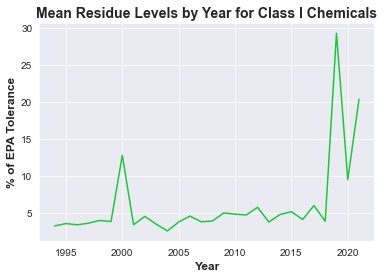

In [27]:
# Create time series plot of mean residue levels by year for Class I toxicity
class_I_by_year = class_I.groupby('Year')['Percent of Threshold'].mean()
plt.plot(class_I_by_year.index, class_I_by_year.values)
plt.title('Mean Residue Levels by Year for Class I Chemicals',fontweight='bold',fontsize=14)
plt.xlabel('Year',fontweight='bold',fontsize=12)
plt.ylabel('% of EPA Tolerance',fontweight='bold',fontsize=12)

### Class II

Text(0, 0.5, '% of EPA Tolerance')

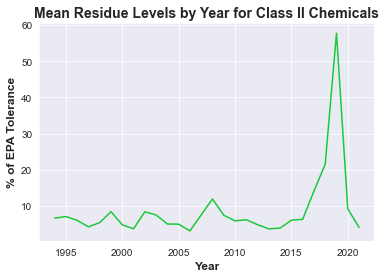

In [28]:
# Create time series plot of mean residue levels by year for Class II toxicity
class_II_by_year = class_II.groupby('Year')['Percent of Threshold'].mean()
plt.plot(class_II_by_year.index, class_II_by_year.values)
plt.title('Mean Residue Levels by Year for Class II Chemicals',fontweight='bold',fontsize=14)
plt.xlabel('Year',fontweight='bold',fontsize=12)
plt.ylabel('% of EPA Tolerance',fontweight='bold',fontsize=12)


### Class III

Text(0, 0.5, '% of EPA Tolerance')

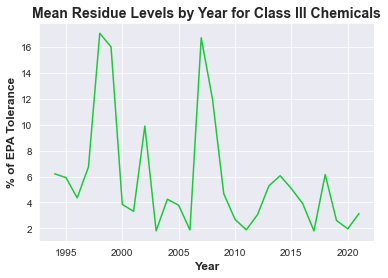

In [29]:
# Create time series plot of mean residue levels by year for Class III toxicity
class_III_by_year = class_III.groupby('Year')['Percent of Threshold'].mean()
plt.plot(class_III_by_year.index, class_III_by_year.values)
plt.title('Mean Residue Levels by Year for Class III Chemicals',fontweight='bold',fontsize=14)
plt.xlabel('Year',fontweight='bold',fontsize=12)
plt.ylabel('% of EPA Tolerance',fontweight='bold',fontsize=12)


### Undefined

Text(0, 0.5, '% of EPA Tolerance')

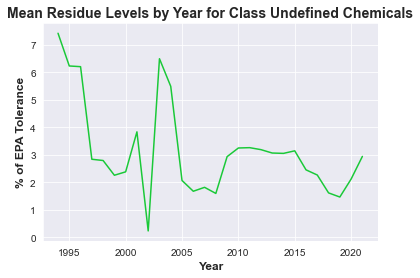

In [30]:
# Create time series plot of mean residue levels by year for undefined toxicity
class_undefined_by_year = undefined.groupby('Year')['Percent of Threshold'].mean()
plt.plot(class_undefined_by_year.index, class_undefined_by_year.values)
plt.title('Mean Residue Levels by Year for Class Undefined Chemicals',fontweight='bold',fontsize=14)
plt.xlabel('Year',fontweight='bold',fontsize=12)
plt.ylabel('% of EPA Tolerance',fontweight='bold',fontsize=12)

## Appendix

Considering the extremely large standard deviation and max values, it would be wise to view the data without the extreme values. This appendix will display the visualizations listed below with only data points in which the Percent of Threshold is less than 1000%. This removes 291 rows of extreme data ranging from 101% to 140,000%. This meaningfully changes the results received for overall mean residue levels over time, removing the spike in 2018-2019 and decreasing the range. Similarly, the results for mean residue by commodity is changed because, as stated earlier, the most extreme values were for pesticides used on basil. Because of this, the mean pesticide residue for basil is decreased. The other figures were not meaningfully changed by removing these potential outliers.

In [31]:
df2 = df[df['Percent of Threshold'] < 1000]

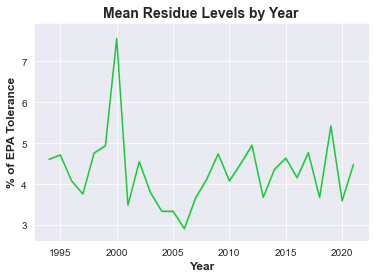

In [32]:
# Create time series plot of mean residue levels by year
residue_by_year2 = df2.groupby('Year')['Percent of Threshold'].agg(['mean', 'std'])
mean_residue_by_year = residue_by_year2['mean']
std_residue_by_year = residue_by_year2['std']
conf_interval = 1.96 * std_residue_by_year / np.sqrt(len(df2))

# Mean residue levels plot with standard deviation line
sns.lineplot(x=mean_residue_by_year.index, y=mean_residue_by_year.values)
plt.fill_between(mean_residue_by_year.index, (mean_residue_by_year - conf_interval).values, (mean_residue_by_year + conf_interval).values, alpha=0.2)

plt.title('Mean Residue Levels by Year', fontweight='bold', fontsize=14)
plt.xlabel('Year', fontweight='bold', fontsize=12)
plt.ylabel('% of EPA Tolerance', fontweight='bold', fontsize=12)

# Show plot
plt.show()

In [33]:
# Create bar chart of mean residue levels by food product
residue_by_product2 = df2.groupby('Commod')['Percent of Threshold'].agg(['mean', 'std'])
mean_residue_by_product = residue_by_product2['mean']
std_residue_by_product = residue_by_product2['std']
conf_interval = 1.96 * std_residue_by_product / np.sqrt(len(df2))

mean_residue_by_product_sorted = mean_residue_by_product.sort_values(ascending=False).head(10)

# Bar chart of mean residue levels with error bars
plt.bar(mean_residue_by_product_sorted.index, mean_residue_by_product_sorted.values, yerr=conf_interval[mean_residue_by_product_sorted.index])
plt.title('Top 10 Food Products by Mean Residue Level', fontweight='bold', fontsize=14)
plt.xlabel('Food Product', fontweight='bold', fontsize=12)
plt.ylabel('% of EPA Tolerance', fontweight='bold', fontsize=12)

# Show plot
plt.show()

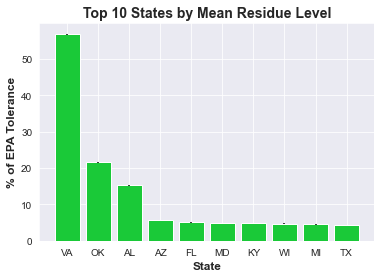

In [34]:
# Create bar chart of mean residue levels by location
residue_by_location2 = df2.groupby('State')['Percent of Threshold'].agg(['mean', 'std'])
mean_residue_by_location = residue_by_location2['mean']
std_residue_by_location = residue_by_location2['std']
conf_interval = 1.96 * std_residue_by_location / np.sqrt(len(df2))

mean_residue_by_location_sorted = mean_residue_by_location.sort_values(ascending=False).head(10)

# Bar chart of mean residue levels with error bars
plt.bar(mean_residue_by_location_sorted.index, mean_residue_by_location_sorted.values, yerr=conf_interval[mean_residue_by_location_sorted.index])
plt.title('Top 10 States by Mean Residue Level', fontweight='bold', fontsize=14)
plt.xlabel('State', fontweight='bold', fontsize=12)
plt.ylabel('% of EPA Tolerance', fontweight='bold', fontsize=12)

# Show plot
plt.show()

In [35]:
# Create bar chart of mean residue levels by pesticide class
residue_by_class2 = df2.groupby('Test Class')['Percent of Threshold'].agg(['mean', 'std'])
mean_residue_by_class = residue_by_class2['mean']
std_residue_by_class = residue_by_class2['std']
conf_interval = 1.96 * std_residue_by_class / np.sqrt(len(df2))

mean_residue_by_class_sorted = mean_residue_by_class.sort_values(ascending=False)

# Bar chart of mean residue levels with error bars
plt.bar(mean_residue_by_class_sorted.index, mean_residue_by_class_sorted.values, yerr=conf_interval[mean_residue_by_class_sorted.index])
plt.title('Mean Residue Levels by Pesticide Class', fontweight='bold', fontsize=14)
plt.xlabel('Pesticide Class', fontweight='bold', fontsize=12)
plt.ylabel('% of EPA Tolerance', fontweight='bold', fontsize=12)

plt.show()

# Food and Agriculture Organization Additional Info

**FAOPest_Amount**

The Pesticides Use database includes data on the use of major pesticide groups (Insecticides, Herbicides, Fungicides, Plant growth regulators and Rodenticides) and of relevant chemical families. Data report the quantities (in tonnes of active ingredients) of pesticides used in or sold to the agricultural sector for crops and seeds. Information on quantities applied to single crops is not available.


**Data shows that Herbicides are most common in the USA by far, Insecticides are the second most common.**

In [37]:

# Use of each major pesticide by tonnes:
FAOPest_Amount = pd.read_csv('FAOSTAT_PestDataUS.csv')

plt.grid(color = "grey")
plt.bar(FAOPest_Amount["Item"],FAOPest_Amount["Value"],edgecolor = "Black",color = "darkred")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Pesticide Type")
plt.ylabel("Amount Used")
plt.title("Pesticide Amount Used Per Type")
plt.show()

# Data shows that Herbicides are most common in the USA by far, Insecticides are the second most common. 

# Future Work Ideas:
- Determine the effect of pesticide residues in regard to climate change. 
- Build a visualization system that can predict pesticide levels and health issues from pesticide contamination in food products based on identified trends. 
- Determine what environmental factors affect pesticide usage, (drought, flooding, climate change, etc.) and analyze which environmental conditions correlate with a larger risk of unsafe levels. 

# Acknowledgements:
- We appreciate the opportunity granted by the company Neogen to showcase our Data Science skills and provide meaningful insights that we hope will benefit their research and productivity. 

# References:
- https://www.ams.usda.gov/datasets/pdp/pdpdata (PDP Database)
- https://www.epa.gov/pesticide-registration/data-requirements-pesticide-registration (EPA Limits Info)
- https://ourworldindata.org/pesticides (Additional Data Used)
- https://www.miamiherald.com/news/nation-world/national/article260221880.html (Dirry Dozen Info)
